In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md
!python -m spacy download xx_sent_ud_sm
!pip install --upgrade spacy_langdetect

In [ ]:
!pip install --upgrade gensim==3.8.3

In [ ]:
# Install of a visualizer for LDA
!pip install pyLDAvis==2.1.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.symbols import ORTH
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from tqdm import tqdm
import gc
import dask
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from collections import defaultdict
from sklearn.utils import shuffle
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LsiModel, TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import pickle
import re
import math
import random

## Configuration

In [2]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# For fancy table Display
# %load_ext google.colab.data_table

dask.config.set(num_workers=8, scheduler='processes')

tqdm.pandas()

## Data preprocessing

In [3]:
# Load the metadata
metadata_df = pd.read_csv('./data/metadata.csv', low_memory=False)
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

In [4]:
# Explore the metadata
metadata_df.info()
metadata_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544406 entries, 0 to 544405
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          544406 non-null  object 
 1   sha               183834 non-null  object 
 2   source_x          544406 non-null  object 
 3   title             544158 non-null  object 
 4   doi               298986 non-null  object 
 5   pmcid             193683 non-null  object 
 6   pubmed_id         258178 non-null  object 
 7   license           544406 non-null  object 
 8   abstract          396056 non-null  object 
 9   publish_time      544187 non-null  object 
 10  authors           529539 non-null  object 
 11  journal           508745 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  226293 non-null  object 
 14  arxiv_id          7097 non-null    object 
 15  pdf_json_files    183834 non-null  object 
 16  pmc_json_files    14

,mag_id,s2_id
count,0.0,4.952350e+05
mean,NaN,1.976635e+08
std,NaN,6.753983e+07
min,NaN,9.600000e+01
25%,NaN,2.186196e+08
50%,NaN,2.213713e+08
75%,NaN,2.281010e+08
max,NaN,2.333898e+08


In [5]:
# Drop rows with null abstract
metadata_df = metadata_df.loc[~pd.isna(metadata_df['abstract'])]
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0
544404,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,"Kaiser, Karol; Bryja, Vitezslav",Int J Mol Sci,NaN,NaN,NaN,document_parses/pdf_json/645c9aec6eed5f1c1436a...,document_parses/pmc_js

<ipython-input-6-5b74b6154bb0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['publish_time'] = metadata_df['publish_time'].astype('datetime64')


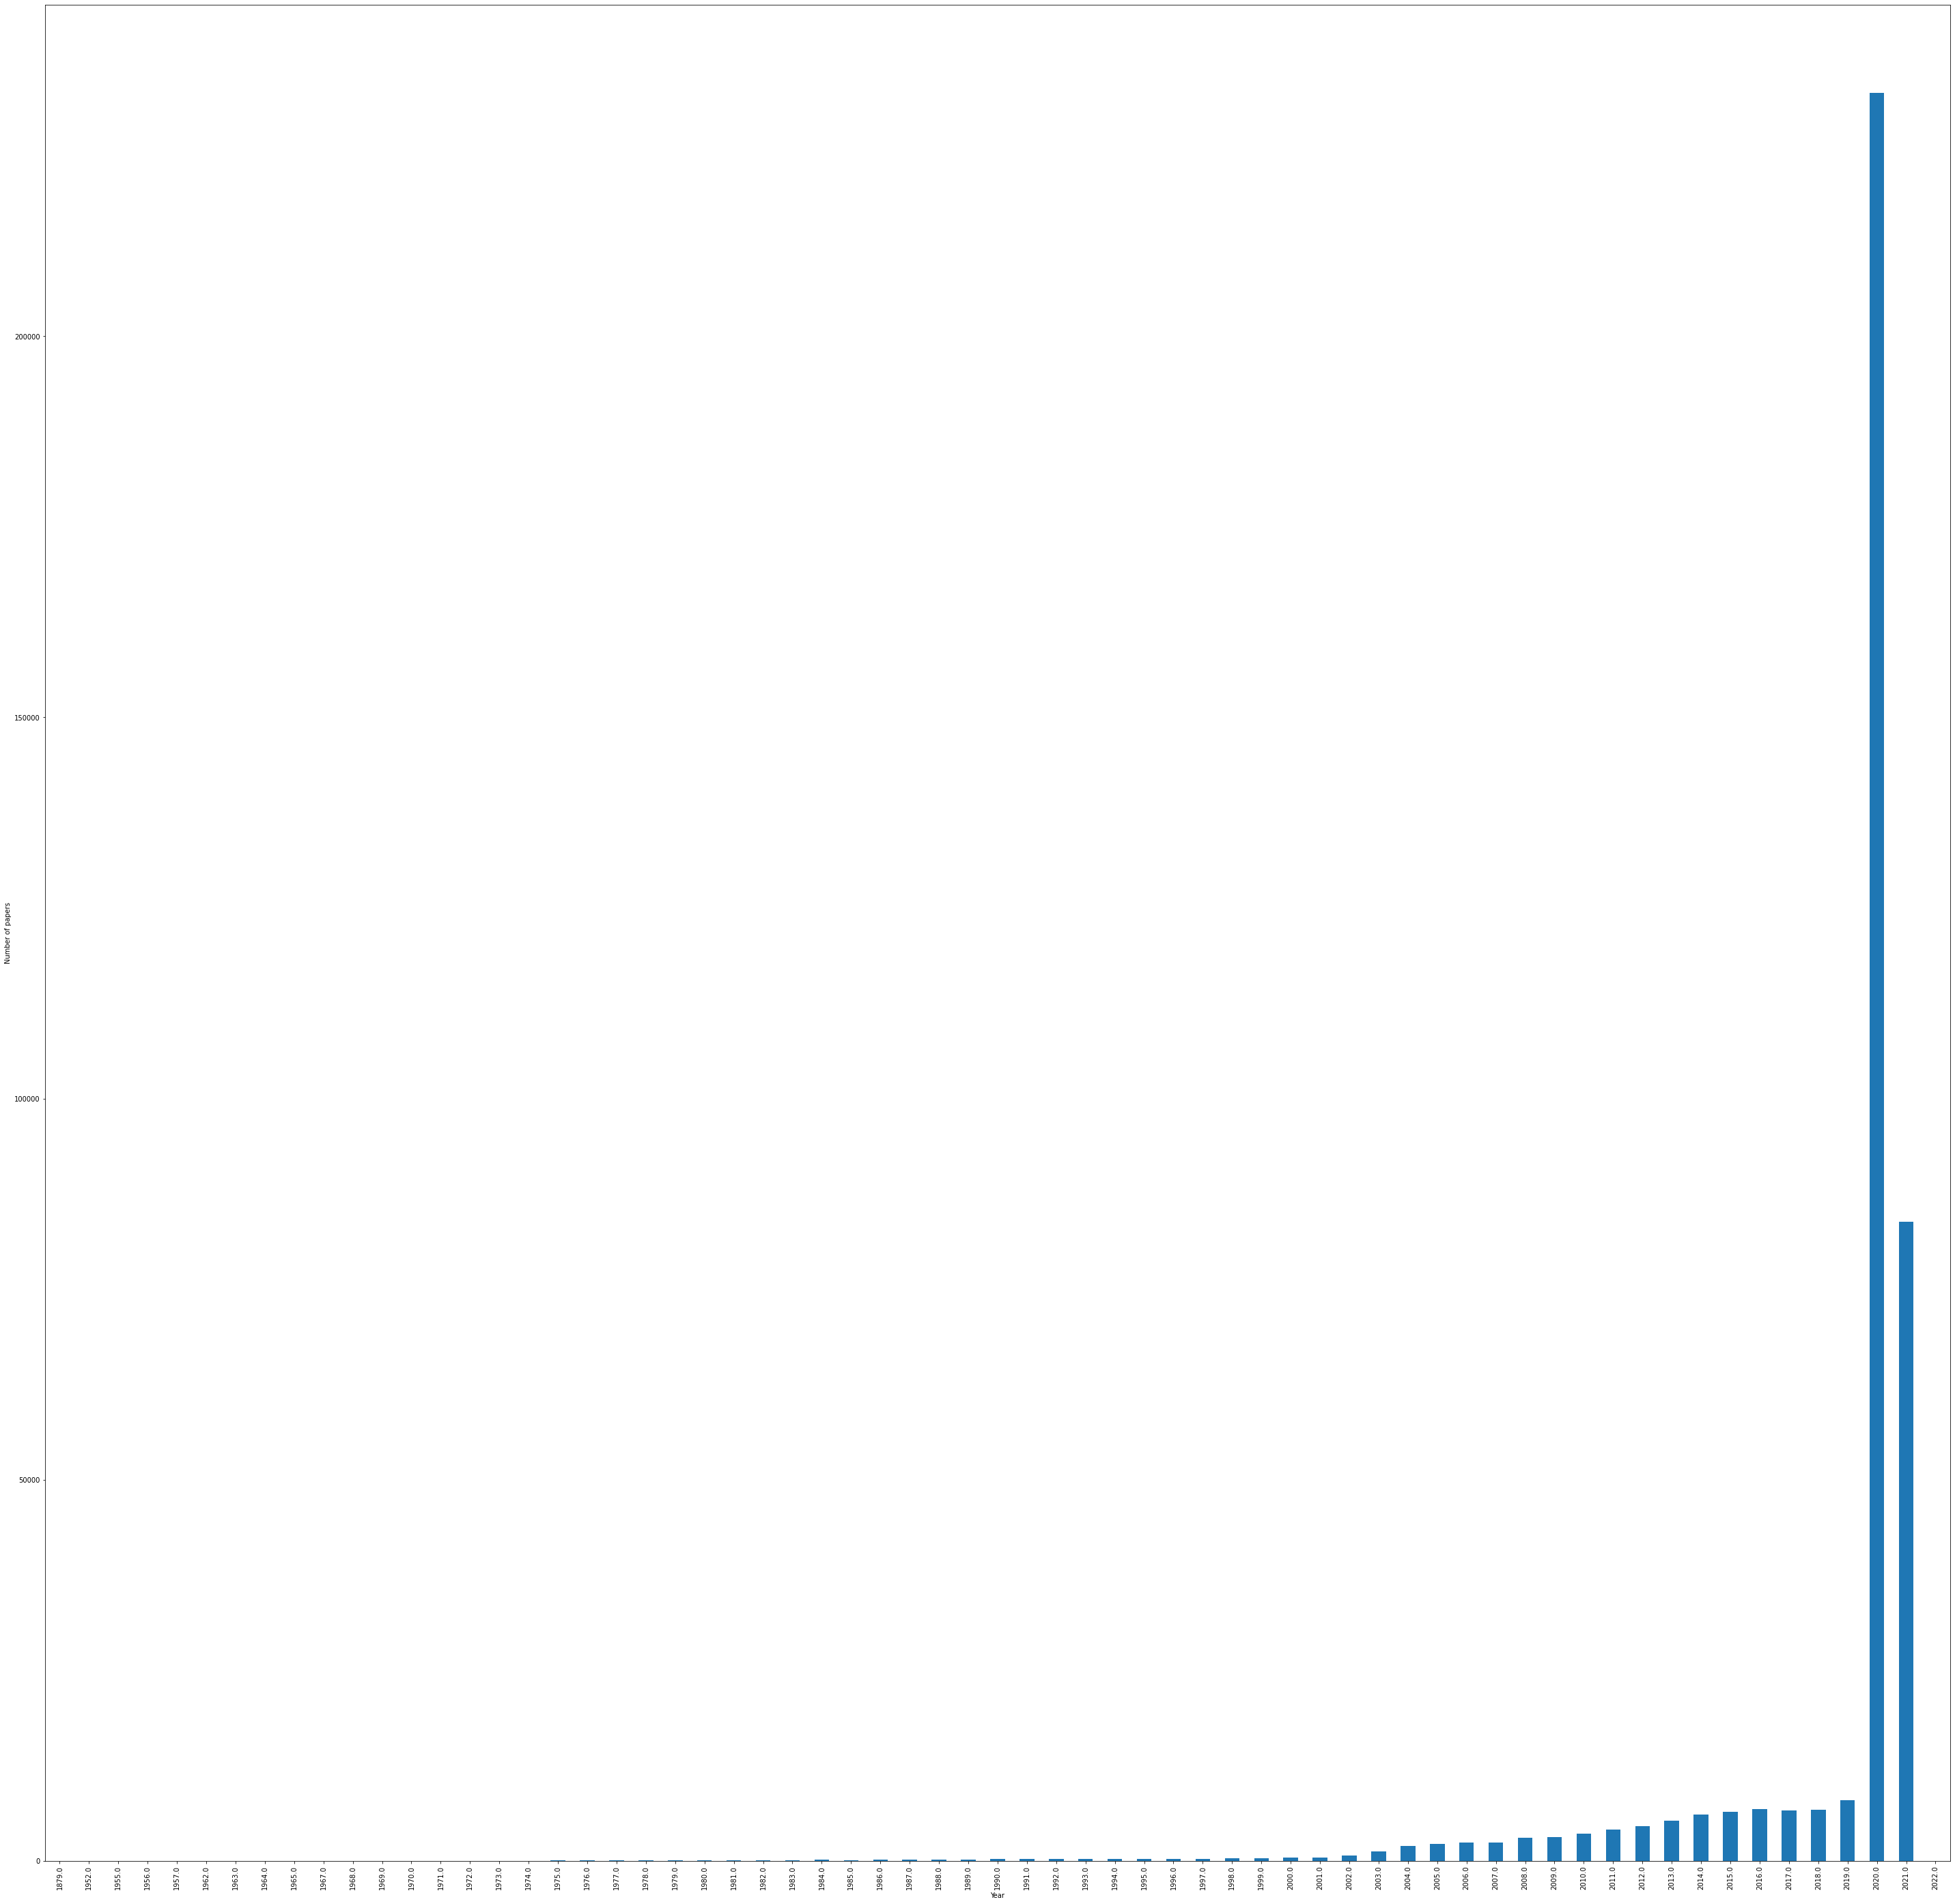

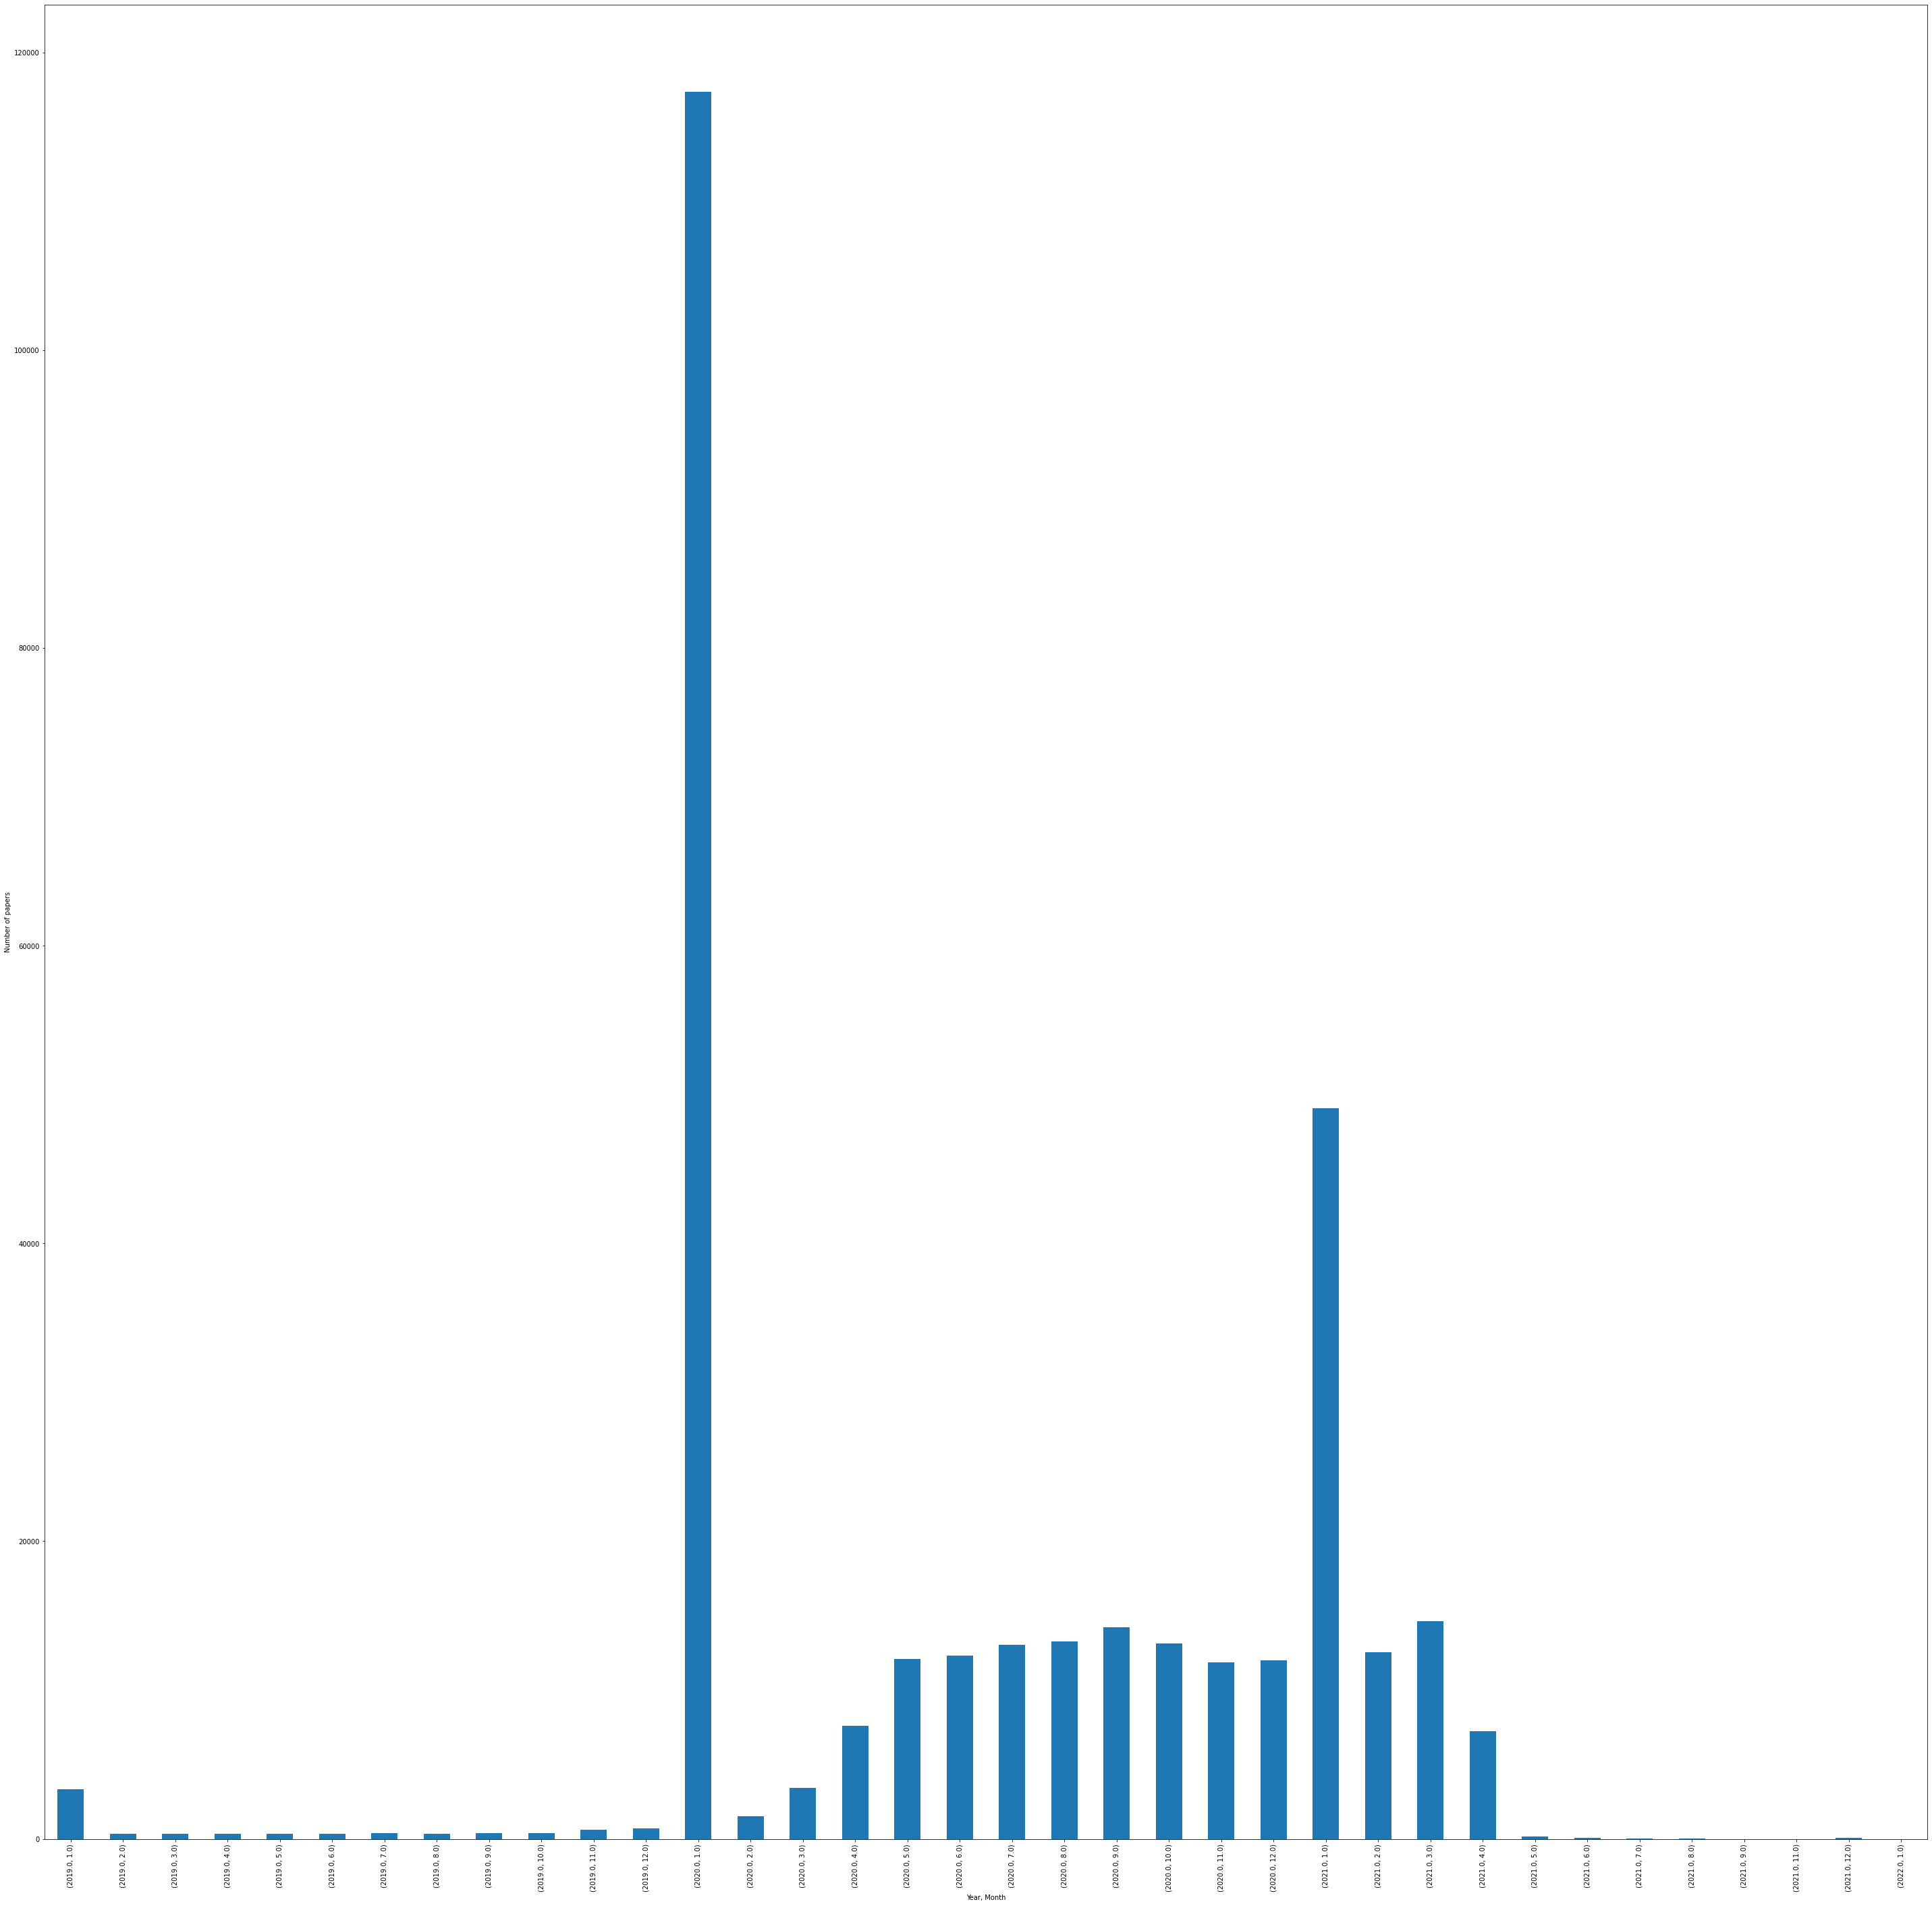

In [6]:
metadata_df['publish_time'] = metadata_df['publish_time'].astype('datetime64')

# Explore the number of published paperes along the years
plt.figure(figsize=(50, 50))
metadata_df['publish_time'].groupby([metadata_df['publish_time'].dt.year]).count().plot(kind='bar')
plt.ylabel('Number of papers')
plt.xlabel('Year')
plt.show()

# Explore the number of published paperes along the last years
plt.figure(figsize=(50, 50))
metadata_df.loc[metadata_df['publish_time'].dt.year >= 2019]['publish_time'].groupby([metadata_df['publish_time'].dt.year, metadata_df['publish_time'].dt.month]).count().plot(kind='bar')
plt.ylabel('Number of papers')
plt.xlabel('Year, Month')
plt.show()

In [9]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

In [10]:
# Explore the abstracts of some random papers to find some special rules for the tokenizer of specific stopwords
for idx, row in shuffle(metadata_df).iloc[:10].iterrows():
    print('==============================================================')
    print(row['title'])
    print(row['publish_time'])
    print()
    print(row['abstract'])
    print()
    doc = nlp(row['abstract'])
    print([tk for tk in doc])
    print()
    print([tk.lemma_ for tk in doc])
    print()
    print([tk.pos_ for tk in doc])
    print()
    print('==============================================================')
    print('\n')

Safety protocols for dental practices in the COVID-19 era
2020-01-01 00:00:00

Aim Aim of this paper was to provide safety and operatory protocols for providing dental care during the COVID19 pandemic.Data sources The protocol is based on summarising the existing literature, published on different aspects of dealing with the pandemic situation. This protocol was established as an international collaboration among three dental universities: Hadassah School of Dental Medicine Israel, the University of Rochester Medical Centre USA, and the University of Pennsylvania USA. The details of the virus-transmission and its impact on dental care are discussed. Additionally, safety and operatory protocols for urgent and emergency dental care are detailed with a special focus on endodontic and surgical dental care.Conclusions A protocol detailing the safety and operatory measures to be taken while giving the dental care in the COVID-era is provided. The primary aim is to prevent any cross-contamina

In [7]:
# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

In [ ]:
mult_nlp = spacy.load('xx_sent_ud_sm')
mult_nlp.add_pipe('language_detector', last=True)

In [8]:
# Explore the vocabulary
results = []
for lex in nlp.vocab:
    r = {}
    r['Term'] = lex.text
    r['Hash'] = lex.orth
    r['Stopword'] = lex.is_stop
    results.append(r)

results_df = pd.DataFrame(results)
results_df

,Term,Hash,Stopword
0,nuthin,17780520906925867008,False
1,ü.,9616619598791593984,False
2,p.m,6364458155313776643,False
3,Kan,8969436956900823045,False
4,Mar,12595687976425261068,False
...,...,...,...
756,She's,7021531544473137138,False
757,ve,10105644630884274164,False
758,E.g.,4115108073383360500,False
759,:-|,280013313535684598,False


In [10]:
# Visualize some stopwords
results_df.loc[results_df['Stopword']]

,Term,Hash,Stopword
14,it,10239237003504588839,True
25,is,3411606890003347522,True
28,Might,9747367433533540424,True
35,where,16318918034475841628,True
46,must,7290638946010101875,True
...,...,...,...
705,They,14947529218328092544,True
714,Had,6865576549405853585,True
733,should,10292920167869855674,True
741,are,5012629990875267006,True


In [9]:
# Add some special cases for the tokenizer
nlp.tokenizer.add_special_case('SARS-CoV-2', [{ORTH: 'SARS'}, {ORTH: '-'}, {ORTH: 'CoV-2'}])
nlp.tokenizer.add_special_case('SARSr-CoV', [{ORTH: 'SARSr'}, {ORTH: '-'}, {ORTH: 'CoV'}])

# Define the valid POS for the abstract tokens
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

def abstract_preprocessing(raw_abstract, mult_nlp, nlp, valid_POS):
    '''
    Preprocess the abstract text to extract only the valid lemmas.
    
    Args:
    - raw_abstract (str): Original abstract string.
    - mult_nlp (spacy.lang.xx.MultiLanguage): Multilanguage Spacy tokenizer.
    - nlp (spacy.lang.en.English): English Spacy tokenizer.
    - valid_POS (set): Set of the string representations of the valid POS.
    
    Returns:
    - lemmas (list): List of the valid lemmas of the given abstract.
    '''
    mult_doc = mult_nlp(raw_abstract)
    english_text = ' '.join([sent.text for sent in mult_doc.sents if sent._.language['language'] == 'en'])
    doc = nlp(english_text)
    
    lemmas = []
    for token in doc:
        if not token.is_stop and (token.is_alpha or token.is_digit) and token.pos_ in valid_POS:
            lemmas.append(token.lemma_)
    
    return lemmas


In [10]:
# Tokenize and lemmatize the data
metadata_df['lemmas'] = metadata_df['abstract'].progress_apply(lambda abstract: abstract_preprocessing(abstract, mult_nlp, nlp, valid_POS))
metadata_df

100%|██████████| 396056/396056 [4:57:21<00:00, 22.20it/s]  
<ipython-input-10-3882f4230122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas'] = metadata_df['abstract'].progress_apply(lambda abstract: abstract_preprocessing(abstract, mult_nlp, nlp, valid_POS))


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544401,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi..."
544402,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla..."
544403,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww.

In [11]:
# Save the preprocessed data
metadata_df.to_csv('./data/metadata_processed.csv', index=False)
nlp.to_disk('./data/en_core_extended')

## Build the corpus

In [3]:
# Load the data
metadata_df = pd.read_csv('./data/metadata_processed.csv', low_memory=False)
metadata_df['lemmas'] = metadata_df['lemmas'].apply(lambda ls_str: [x.strip() for x in eval(ls_str)])
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,"Bhavani, R. V.; Gopinath, R.",Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,"You, Chuanman",Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,"Abuhammad, Sawsan; AlAzzam, Manar; Mukattash, ...",Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww.

Mean number of tokens: 110.74
Median number of tokens: 111.00
Standard deviation number of tokens: 62.15


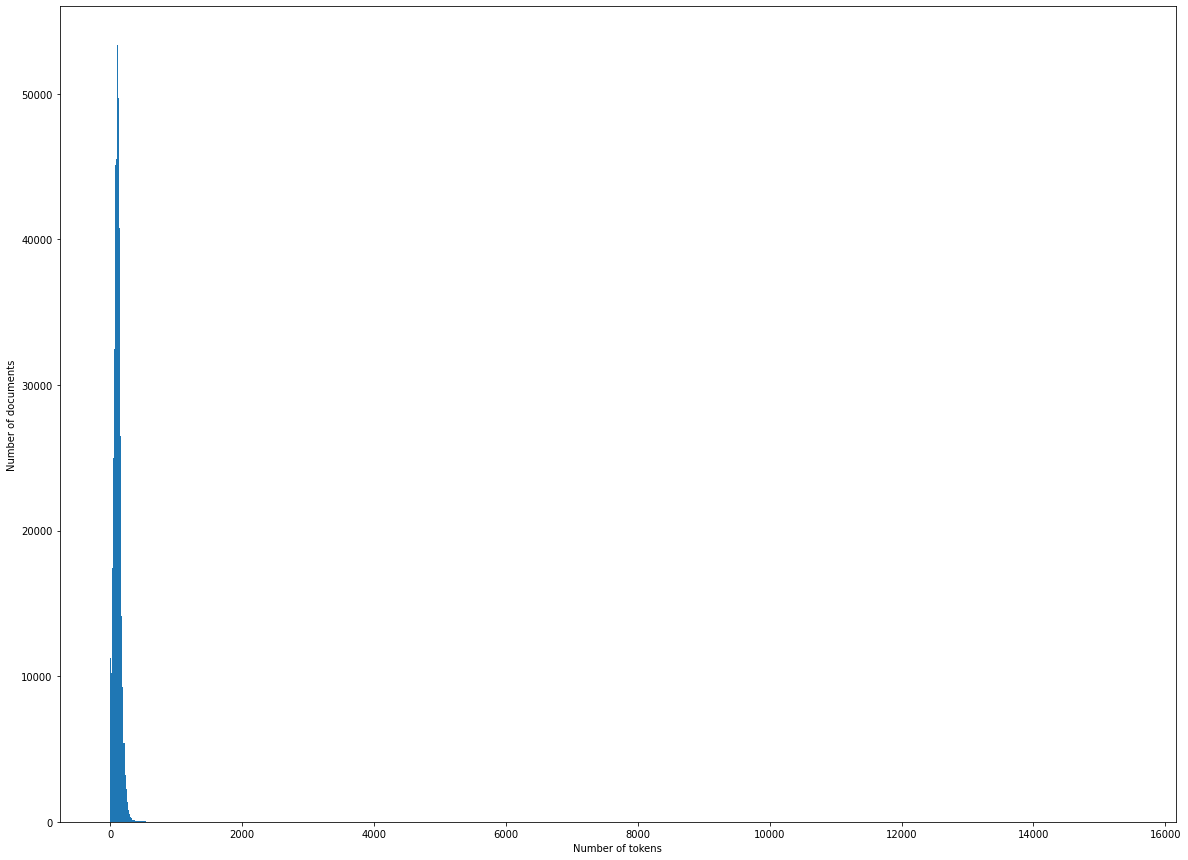

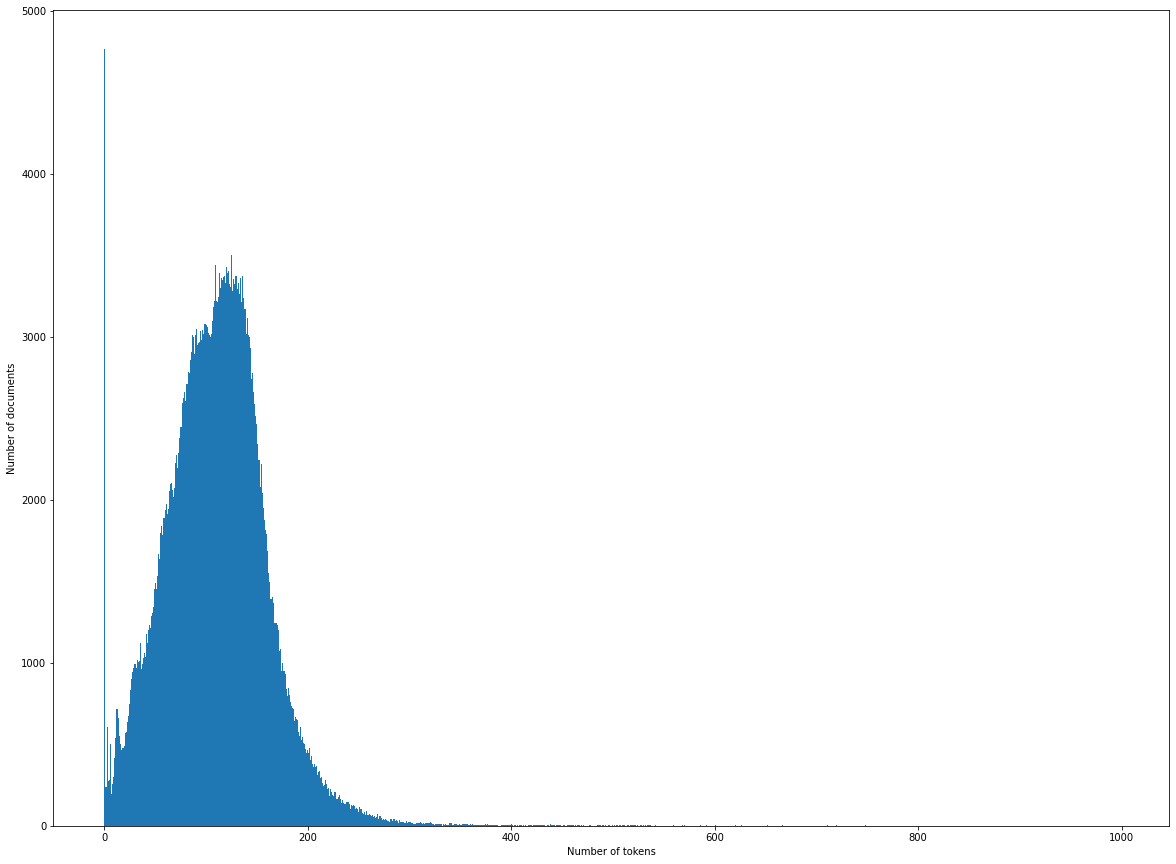

In [4]:
# Explore the number of tokens per document
n_tokens_aux = metadata_df['lemmas'].apply(lambda x: len(x))

print('Mean number of tokens: {:.2f}'.format(n_tokens_aux.mean()))
print('Median number of tokens: {:.2f}'.format(n_tokens_aux.median()))
print('Standard deviation number of tokens: {:.2f}'.format(n_tokens_aux.std()))

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux, bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux[n_tokens_aux < 1000], bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

In [5]:
# Drop the papers with extreamly short abstracts
metadata_df['nlemmas'] = metadata_df['lemmas'].apply(len)
metadata_df = metadata_df[metadata_df['nlemmas'] > 20]
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,Food Secur,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,Computer Law & Security Review,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,Int J Clin Pract,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https://ww...,228089464.0,"[study, aim, evaluate, available, content, loc...",102
396054,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrosp

In [6]:
# Drop lemmas composed by only one character
metadata_df['lemmas_clean'] = metadata_df['lemmas'].progress_apply(lambda lemmas: [l for l in lemmas if len(l) >= 2])
metadata_df

100%|██████████| 382386/382386 [00:14<00:00, 26780.17it/s]
<ipython-input-6-b5632ec64aab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas_clean'] = metadata_df['lemmas'].progress_apply(lambda lemmas: [l for l in lemmas if len(l) >= 2])


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas,lemmas_clean
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69,"[inflammatory, disease, respiratory, tract, as..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133,"[surfactant, protein, SP, participate, innate,..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https:/

In [7]:
# Remove the specific stopwords from the lemmas
specific_stw = set(['study', 'result', 'include', 'conclusion', 'base', 'report', 'provide', 'case', 'method', 
                    'present', 'identify', 'show', 'associate', 'compare', 'use', 'aim', 'need', 'find', 'paper',
                    'research', 'propose', 'follow'])


metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: [lemma for lemma in lemmas if lemma not in specific_stw])
metadata_df

100%|██████████| 382386/382386 [00:10<00:00, 37476.43it/s] 
<ipython-input-7-c2e712b83d8b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: [lemma for lemma in lemmas if lemma not in specific_stw])


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas,lemmas_clean
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69,"[inflammatory, disease, respiratory, tract, el..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133,"[surfactant, protein, SP, participate, innate,..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https:/

In [8]:
# Build specific unigrams
unigram_dict = {
    'cerebrospinal fluid' : 'CSF', 
    'cerebral palsy': 'CP', 
    'machine learning': 'ML',
    'deep learning': 'DL',
    'computerized tomography': 'CT',
    'computed tomography': 'CT',
    'porcine epidemic diarrhea virus': 'PEDV',
    'magnetic resonance imaging': 'MRI',
    'multiple sclerosis': 'MS',
    'electrocardiogram': 'ECG',
    'EKG': 'ECG',
}

pattern_unigrams = re.compile(r'\b(' + '|'.join([k for k in unigram_dict]) + r')\b')

metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: pattern_unigrams.sub(lambda x: unigram_dict[x.group()], ' '.join(lemmas)).split(' '))
metadata_df

100%|██████████| 382386/382386 [00:35<00:00, 10628.46it/s]
<ipython-input-8-a820050a0f92>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['lemmas_clean'] = metadata_df['lemmas_clean'].progress_apply(lambda lemmas: pattern_unigrams.sub(lambda x: unigram_dict[x.group()], ' '.join(lemmas)).split(' '))


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,lemmas,nlemmas,lemmas_clean
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"[retrospective, chart, review, describe, epide...",129,"[retrospective, chart, review, describe, epide..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[inflammatory, disease, respiratory, tract, as...",69,"[inflammatory, disease, respiratory, tract, el..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[surfactant, protein, d, SP, D, participate, i...",133,"[surfactant, protein, SP, participate, innate,..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[amino, acid, peptide, diverse, biological, ac...",35,"[amino, acid, peptide, diverse, biological, ac..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,"[respiratory, syncytial, virus, RSV, pneumonia...",68,"[respiratory, syncytial, virus, RSV, pneumonia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396051,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,NaN,NaN,NaN,document_parses/pdf_json/1fca7a77b04fc4a1b326c...,document_parses/pmc_json/PMC7343897.xml.json,https://doi.org/10.1007/s12571-020-01071-6; ht...,220417712.0,"[pandemic, see, wake, humanity, reflect, rethi...",71,"[pandemic, see, wake, humanity, reflect, rethi..."
396052,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,NaN,NaN,NaN,document_parses/pdf_json/91351188e43719fe66f83...,NaN,https://www.sciencedirect.com/science/article/...,225041999.0,"[China, experience, phenomenal, expansion, pla...",112,"[China, experience, phenomenal, expansion, pla..."
396053,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,NaN,NaN,NaN,document_parses/pdf_json/612fef2d60ed24807bf9c...,document_parses/pmc_json/PMC7883258.xml.json,https://doi.org/10.1111/ijcp.13919; https:/

Mean number of tokens: 106.79
Median number of tokens: 105.00
Standard deviation number of tokens: 56.94


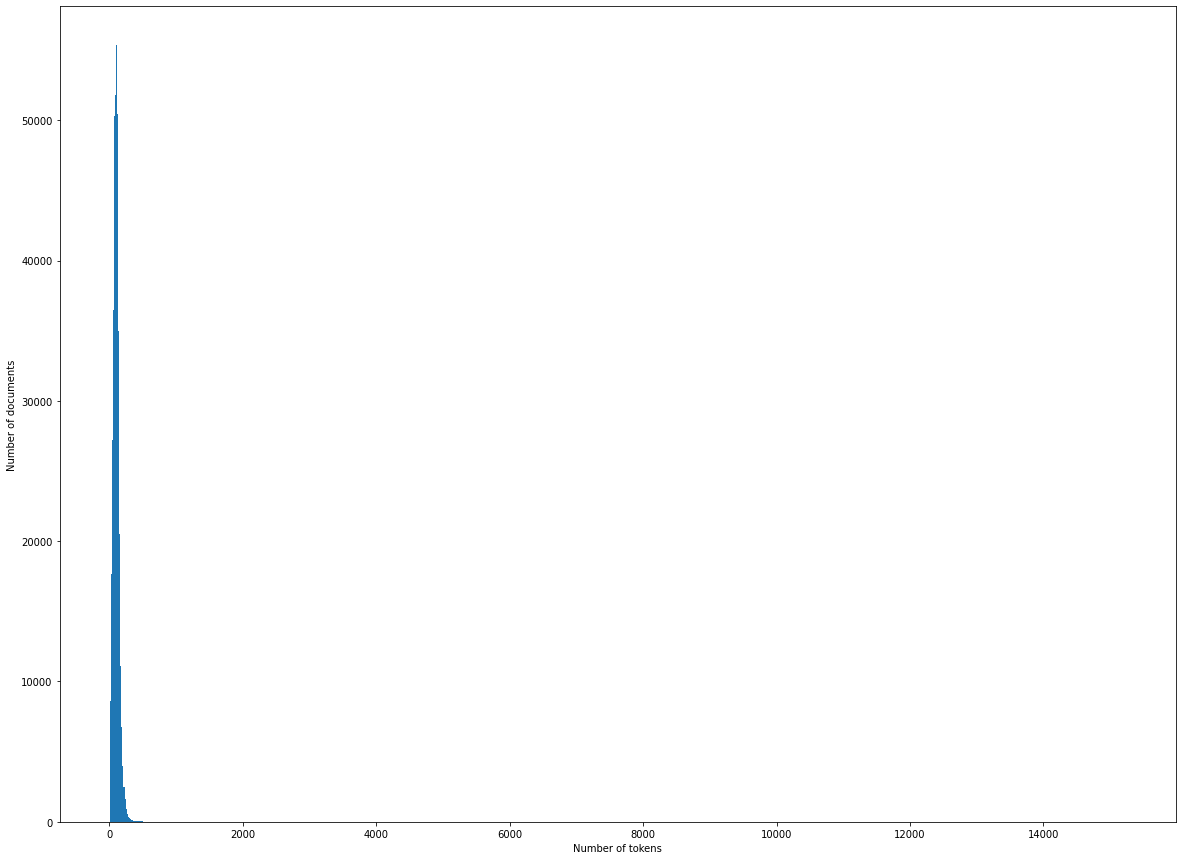

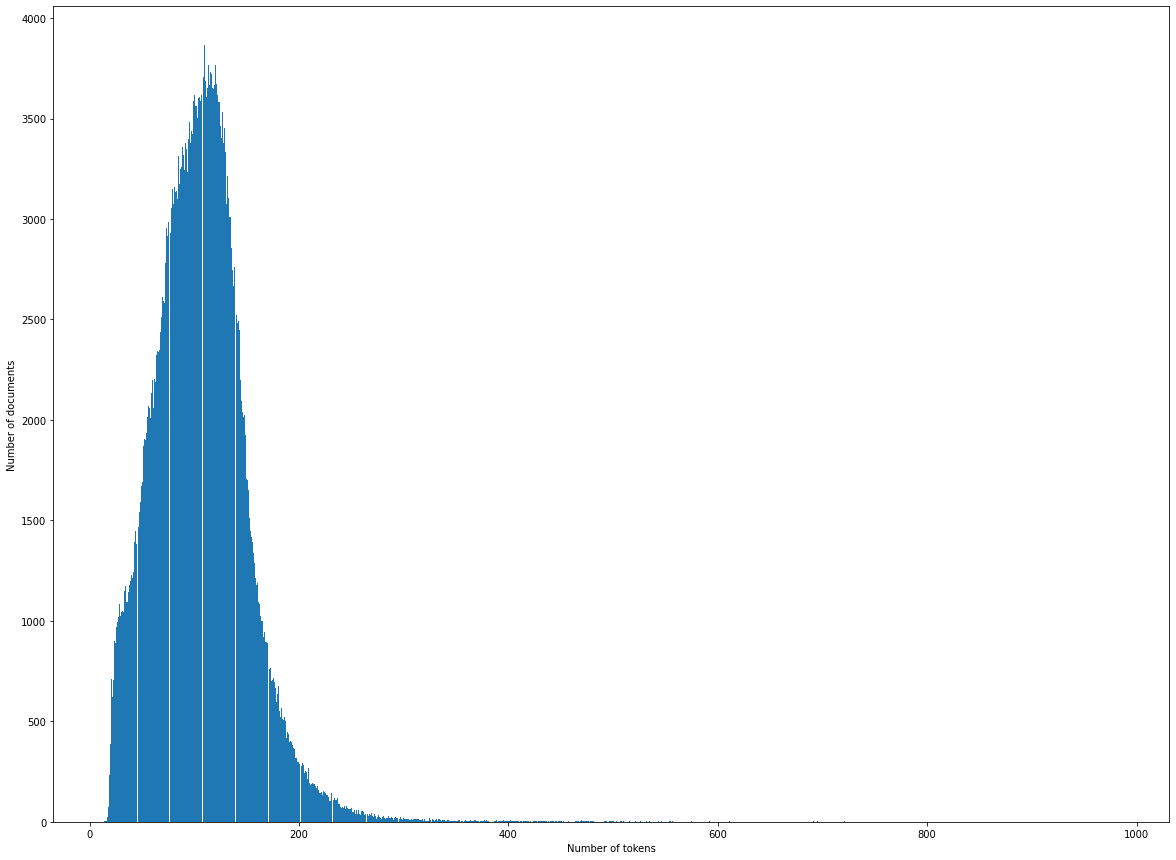

In [9]:
# Explore the number of tokens per document after the cleaning
n_tokens_aux = metadata_df['lemmas_clean'].apply(lambda x: len(x))

print('Mean number of tokens: {:.2f}'.format(n_tokens_aux.mean()))
print('Median number of tokens: {:.2f}'.format(n_tokens_aux.median()))
print('Standard deviation number of tokens: {:.2f}'.format(n_tokens_aux.std()))

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux, bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

plt.figure(figsize=(20,15))
plt.hist(n_tokens_aux[n_tokens_aux < 1000], bins=1000)
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

In [10]:
# Build the corpus and compute N-gram detection and replacement
corpus = metadata_df['lemmas_clean'].to_list()
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print('\n============= First document in corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]]
print('\n============= First document after N-gram replacement =============')
print(corpus[0])


============= First document in corpus =============
['retrospective', 'chart', 'review', 'describe', 'epidemiology', 'clinical', 'feature', 'patient', 'culture', 'prove', 'Mycoplasma', 'pneumoniae', 'infection', 'King', 'Abdulaziz', 'University', 'Hospital', 'Jeddah', 'Saudi', 'Arabia', 'patient', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimen', 'January', 'December', 'Microbiology', 'record', 'chart', 'patient', 'review', 'patient', 'require', 'admission', 'infection', 'community', 'acquire', 'infection', 'affect', 'age', 'group', 'common', 'infant', 'pre', 'school', 'child', 'occur', 'year', 'round', 'common', 'fall', 'spring', 'quarter', 'patient', 'comorbiditie', 'isolate', 'pneumonia', 'upper', 'respiratory', 'tract', 'infection', 'bronchiolitis', 'Cough', 'fever', 'malaise', 'common', 'symptom', 'crepitation', 'wheeze', 'common', 'sign', 'patient', 'pneumonia', 'crepitation', 'bronchial', 'breathing', 'immunocompromised', 'patient', 'likely', 'non', 'immunocompro

In [11]:
# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 454416 terms
First terms in the dictionary:
0 : Arabia
1 : Cough_fever
2 : January_December
3 : Jeddah_Saudi
4 : King_Abdulaziz
5 : Microbiology
6 : Mycoplasma_pneumoniae
7 : University_Hospital
8 : admission
9 : affect


In [12]:
df_aux = pd.DataFrame([{'token': D[idx], 'ndocs': val} for idx, val in D.dfs.items()])

just_one_doc = df_aux.loc[df_aux['ndocs'] == 1]
print('Number of tokens appearing in just one document: {}'.format(len(just_one_doc)))
df_aux = df_aux.loc[df_aux['ndocs'] != 1]

df_aux = df_aux.sort_values('ndocs', ascending=False)

print(df_aux.head(20))
print(df_aux.tail(20))

Number of tokens appearing in just one document: 129442
             token   ndocs
6          patient  149014
71         disease  140090
1362      pandemic  124662
69            high  117177
10       infection  106019
64           datum   93253
76        increase   92191
4         clinical   86747
852           SARS   83948
23134  coronavirus   80115
1266          risk   76824
464       analysis   75478
174          virus   75304
563           time   73800
633      treatment   71679
345         health   67779
216          cause   67694
316          level   65373
315            low   62777
713        develop   62669
                          token  ndocs
253743  adventitious_endogenous      2
253739                  oestrus      2
253738                anoestrus      2
253737                 AChEI_CS      2
253736            receive_AChEI      2
28044                     Aslan      2
253699                rinse_CHO      2
253673                    EBLCs      2
253698          cycling_ev

In [13]:
df_aux.describe()

,ndocs
count,324974.000000
mean,79.883354
std,1251.206881
min,2.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,149014.000000


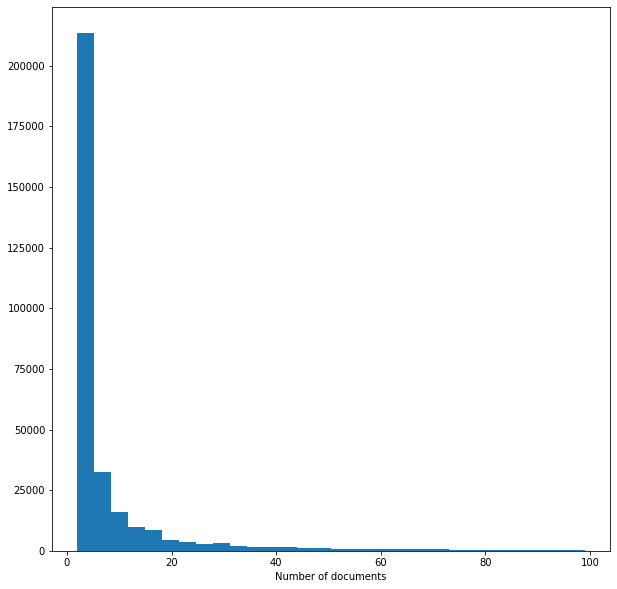

In [14]:
plt.figure(figsize=(10, 10))
plt.hist(df_aux['ndocs'][df_aux['ndocs'] < 100], bins=30)
plt.xlabel('Number of documents')
plt.show()

In [15]:
no_below = 8 # Minimum number of documents to keep a term in the dictionary
no_above = .80 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 87141 terms


In [16]:
df_aux = pd.DataFrame([{'token': D[idx], 'ndocs': val} for idx, val in D.dfs.items()])
df_aux = df_aux.sort_values('ndocs', ascending=False)

print(df_aux.head(20))
print(df_aux.tail(20))

             token   ndocs
6          patient  149014
70         disease  140090
1287      pandemic  124662
68            high  117177
10       infection  106019
64           datum   93253
75        increase   92191
4         clinical   86747
815           SARS   83948
17996  coronavirus   80115
1193          risk   76824
454       analysis   75478
170          virus   75304
543           time   73800
609      treatment   71679
340         health   67779
212          cause   67694
311          level   65373
310            low   62777
687        develop   62669
                        token  ndocs
80499         chebulagic_acid      8
37575          alpaca_Vicugna      8
80479        sleepiness_sleep      8
80459          stomach_spleen      8
65899             blur_vision      8
46838                  Javier      8
65897         liquid_impinger      8
80463         fecal_flotation      8
80464                     TAZ      8
80465               MCS_score      8
24932  Surveillance_Progra

In [17]:
corpus_bow = [D.doc2bow(doc) for doc in corpus]

n_project = 1000
print('============= Project abstract (lemmas) =============')
print(' '.join(corpus[n_project]))

print('\n============= Sparse vector representation =============')
print(corpus_bow[n_project])

print('\n============= Word counts for the project =============')
print(list(map(lambda x: (D[x[0]], x[1]), corpus_bow[n_project])))

============= Project abstract (lemmas) =============
human_bocavirus HBoV_discover child respiratory_distress diarrhea knowledge previous existence bocavirus Saudi_Arabia swab sample child respiratory_tract infection examine presence real_time polymerase_chain reaction sensitive detect direct gene sequence determine genotype detect virus isolate HBoV detect examine patient partial gene sequence patient circulate strain relate genotype HBoV infected patient evidence mixed coinfection viral pathogen current demonstrate conserve circulate Saudi_Arabia infected high rate co infection virus

============= Sparse vector representation =============
[(15, 2), (31, 1), (34, 2), (35, 1), (41, 3), (49, 1), (84, 1), (116, 1), (185, 2), (218, 1), (226, 2), (236, 1), (237, 1), (238, 1), (249, 1), (259, 1), (262, 1), (291, 2), (460, 1), (544, 1), (571, 1), (576, 2), (610, 3), (710, 1), (1012, 1), (1014, 1), (1033, 2), (1124, 1), (1130, 1), (1257, 1), (1422, 1), (1664, 1), (1958, 2), (1966, 1), (197

## ❤️ CHECKPOINT ❤️

In [18]:
# Save the metadata dataframe
metadata_df.to_csv('./data/metadata_processed_2.csv', index=False)
# Save the dictionary
D.save('./data/gensim_dictionary')
# Save corpus
pickle.dump(corpus, open('./data/corpus.pkl', 'wb'))
# Save corpus
pickle.dump(corpus_bow, open('./data/corpus_bow.pkl', 'wb'))

In [3]:
# Load the metadata dataframe
metadata_df = pd.read_csv('./data/metadata_processed_2.csv', low_memory=False)
# Load the dictionary
D = Dictionary.load('./data/gensim_dictionary')
# Load corpus
corpus = pickle.load(open('./data/corpus.pkl', 'rb'))
# Load corpus
corpus_bow = pickle.load(open('./data/corpus_bow.pkl', 'rb'))

## Find appropiate number of topics

 17%|█▋        | 1/6 [07:00<35:03, 420.75s/it]

Estimated coherence for a model with 5 topics: 0.5070


 33%|███▎      | 2/6 [11:42<22:36, 339.07s/it]

Estimated coherence for a model with 10 topics: 0.5682


 50%|█████     | 3/6 [17:48<17:33, 351.17s/it]

Estimated coherence for a model with 15 topics: 0.5418


 67%|██████▋   | 4/6 [25:17<12:59, 389.79s/it]

Estimated coherence for a model with 20 topics: 0.5848


 83%|████████▎ | 5/6 [34:07<07:20, 440.43s/it]

Estimated coherence for a model with 25 topics: 0.5626


100%|██████████| 6/6 [48:01<00:00, 480.31s/it]

Estimated coherence for a model with 50 topics: 0.5007
Best number of topics: 20


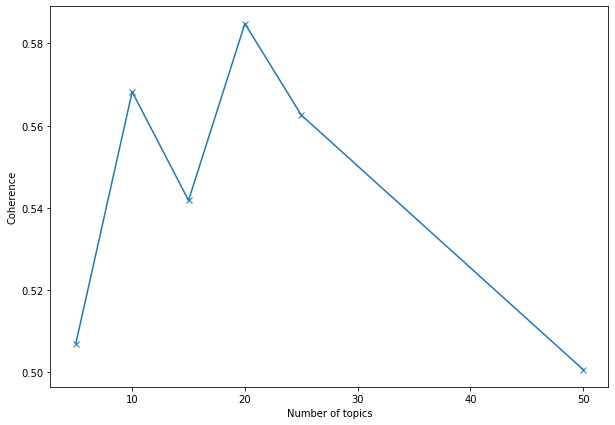

In [19]:
# Search for the ideal number of topics
n_topics = [5, 10, 15, 20, 25, 50]

coh_ls = []
for nt in tqdm(n_topics):

    ldag_n = LdaModel(corpus=corpus_bow, id2word=D, num_topics=nt)
    coherencemodel = CoherenceModel(ldag_n, texts=corpus, dictionary=D, coherence='c_v')

    coh = coherencemodel.get_coherence()
    print('Estimated coherence for a model with {} topics: {:.4f}'.format(nt, coh))
    coh_ls.append(coh)

best_n_topics = n_topics[np.argmax(coh_ls)]
print('Best number of topics:', best_n_topics)

plt.figure(figsize=(10,7))
plt.plot(n_topics, coh_ls, marker='x')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

In [ ]:
# Search for the ideal number of topics in a more precise approx
n_topics = list(range(best_n_topics - 4, best_n_topics + 5))

coh_ls = []
for nt in tqdm(n_topics):

    ldag_n = LdaModel(corpus=corpus_bow, id2word=D, num_topics=nt)
    coherencemodel = CoherenceModel(ldag_n, texts=corpus, dictionary=D, coherence='c_v')

    coh = coherencemodel.get_coherence()
    print('Estimated coherence for a model with {} topics: {:.4f}'.format(nt, coh))
    coh_ls.append(coh)

best_n_topics = n_topics[np.argmax(coh_ls)]
print('Best number of topics:', best_n_topics)

plt.figure(figsize=(10,7))
plt.plot(n_topics, coh_ls, marker='x')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.show()

 11%|█         | 1/9 [05:54<47:16, 354.59s/it]

Estimated coherence for a model with 16 topics: 0.5491


 22%|██▏       | 2/9 [12:06<42:34, 365.00s/it]

Estimated coherence for a model with 17 topics: 0.5669


 33%|███▎      | 3/9 [18:40<37:49, 378.29s/it]

Estimated coherence for a model with 18 topics: 0.5256


 44%|████▍     | 4/9 [25:17<32:07, 385.50s/it]

Estimated coherence for a model with 19 topics: 0.5635


 56%|█████▌    | 5/9 [32:27<26:46, 401.56s/it]

Estimated coherence for a model with 20 topics: 0.5721


 67%|██████▋   | 6/9 [39:37<20:33, 411.31s/it]

Estimated coherence for a model with 21 topics: 0.5684


 78%|███████▊  | 7/9 [47:25<14:19, 429.90s/it]

Estimated coherence for a model with 22 topics: 0.5326


## ❤️ CHECKPOINT ❤️

In [4]:
metadata_df = pd.read_csv('./data/metadata_processed_2.csv', low_memory=False)
D = Dictionary.load('./data/gensim_dictionary')
corpus = pickle.load(open('./data/corpus.pkl', 'rb'))
corpus_bow = pickle.load(open('./data/corpus_bow.pkl', 'rb'))

## Topic modelling - Final LDA model

In [4]:
best_n_topics = 20
# Train LDA model
ldag = LdaModel(corpus=corpus_bow, id2word=D, num_topics=best_n_topics)
ldag.save('./data/lda.model')

# Display all topics including 10 most relevant tokens per topic
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.044*"sequence" + 0.040*"gene" + 0.035*"strain" + 0.030*"genome" + 0.027*"mutation" + 0.025*"variant" + 0.023*"analysis" + 0.020*"genetic" + 0.020*"isolate" + 0.014*"region"'),
 (1,
  '0.029*"age" + 0.027*"year" + 0.023*"rate" + 0.023*"increase" + 0.022*"death" + 0.022*"period" + 0.019*"influenza" + 0.019*"pandemic" + 0.016*"vaccine" + 0.016*"high"'),
 (2,
  '0.023*"structure" + 0.010*"process" + 0.009*"form" + 0.009*"interaction" + 0.009*"complex" + 0.008*"surface" + 0.008*"particle" + 0.008*"site" + 0.007*"function" + 0.007*"structural"'),
 (3,
  '0.032*"cell" + 0.022*"disease" + 0.014*"infection" + 0.013*"immune" + 0.012*"response" + 0.011*"role" + 0.011*"expression" + 0.011*"lung" + 0.010*"induce" + 0.009*"increase"'),
 (4,
  '0.028*"surgery" + 0.026*"lung" + 0.022*"surgical" + 0.020*"CT" + 0.018*"perform" + 0.018*"image" + 0.015*"procedure" + 0.014*"undergo" + 0.013*"volume" + 0.012*"time"'),
 (5,
  '0.068*"SARS" + 0.046*"disease" + 0.044*"infection" + 0.030*"virus" + 0.0

In [5]:
ldag = LdaModel.load('./data/lda.model')
best_n_topics = len(ldag.show_topics(num_topics=-1))

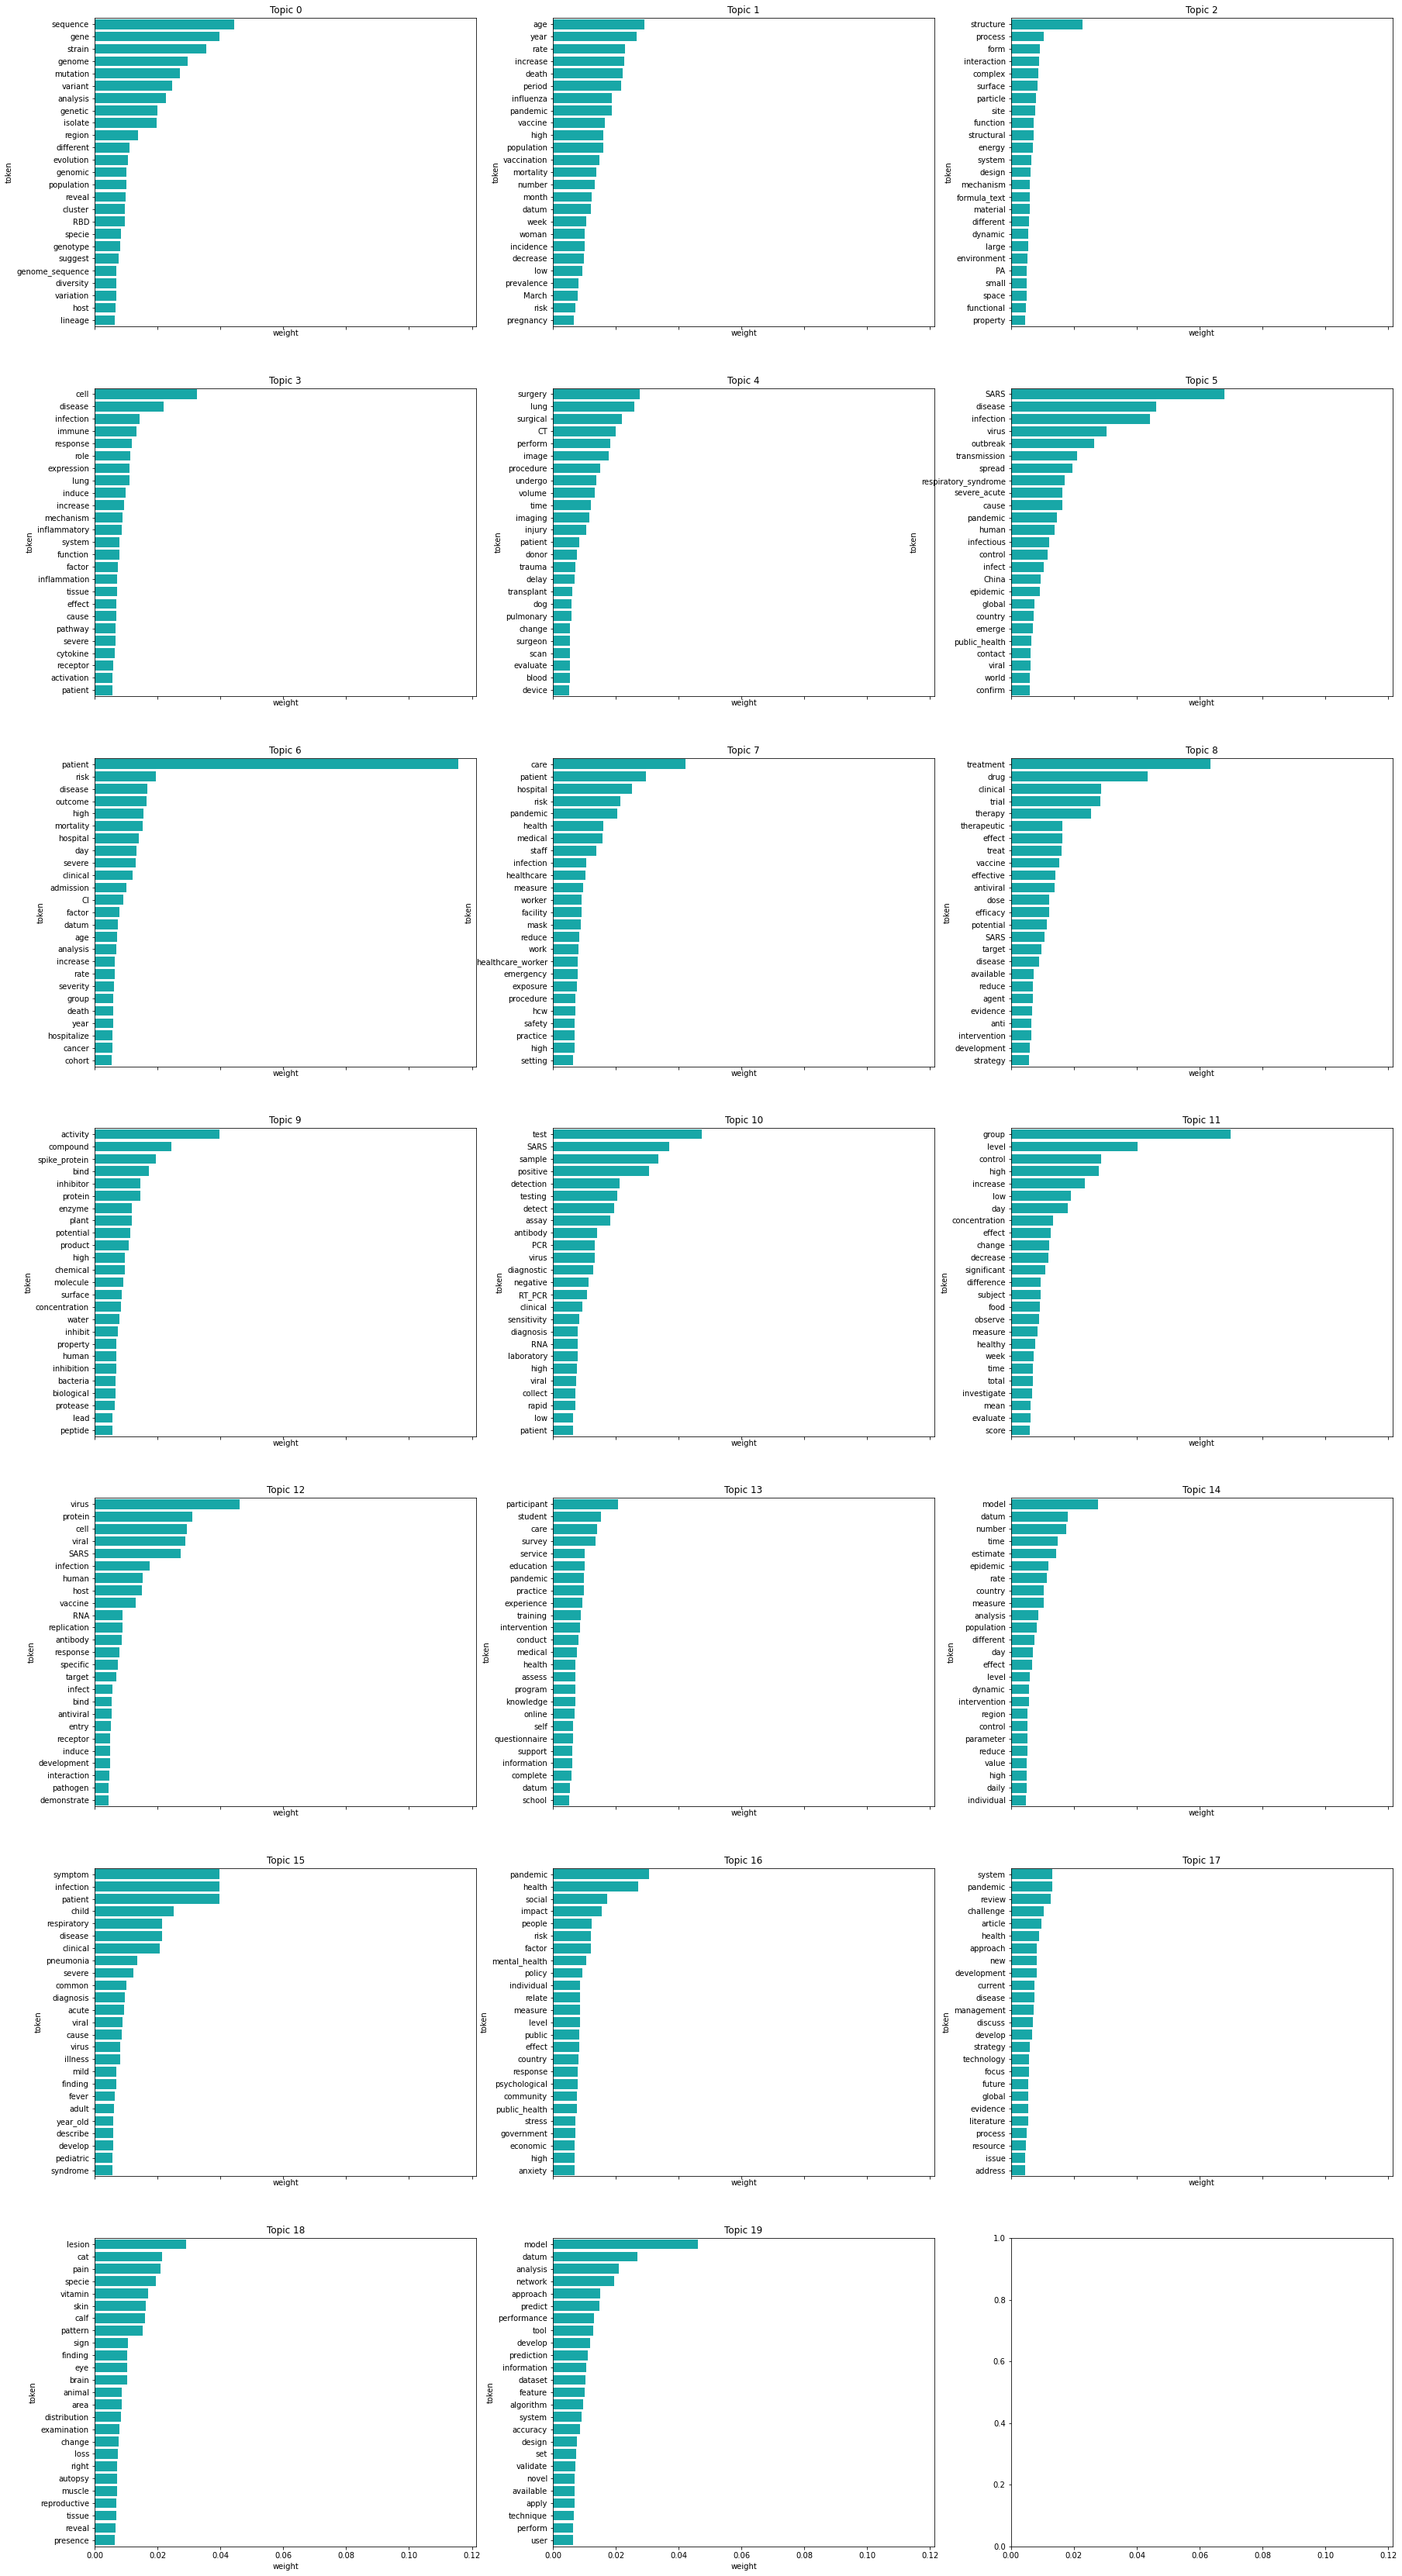

In [5]:
plots_per_row = 3
topn = 25

fig, axes = plt.subplots(math.ceil(best_n_topics / plots_per_row), plots_per_row, figsize=(30, 60), sharex=True)
x = 0

for i in range(best_n_topics):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df_weights = pd.DataFrame([{'token': t, 'weight': w} for t, w in ldag.show_topic(i, topn=topn)])
    
    ax = axes[x][i - (plots_per_row * x)]
    x += 1 if (i + 1) % plots_per_row == 0 else 0
    sns.barplot(x='weight', y='token', data=df_weights, color='c', orient='h', ax=ax)
    ax.set_title('Topic ' + str(i))
    
plt.show()

In [6]:
# Compute the coherence per topic
coherencemodel = CoherenceModel(ldag, texts=corpus, dictionary=D, coherence='c_v')
print('The coherence of the trained model is', coherencemodel.get_coherence())

df_coherence = pd.DataFrame([{'topic_id': i, 'coherence': c} for i, c in enumerate(coherencemodel.get_coherence_per_topic())])
df_coherence.sort_values('coherence', ascending=False)

The coherence of the trained model is 0.5579485810917211


,topic_id,coherence
12,12,0.773175
10,10,0.696048
0,0,0.694654
9,9,0.688293
13,13,0.640132
5,5,0.638963
3,3,0.613151
8,8,0.580046
15,15,0.575644
17,17,0.549455


In [7]:
# Visualize the 2D PCA of the LDA model
vis_data = gensimvis.prepare(ldag, corpus_bow, D)
pyLDAvis.display(vis_data)

In [8]:
def most_relevant_documents(ldag, topicid, corpus_bow, ndocs=10):
    '''
    This function returns the most relevant documents in corpus_bow
    
    Args:
    - ldag: The trained topic model object provided by gensim
    - topicid: The topic for which we want to find the most relevant documents
    - corpus_bow: The BoW representation of documents in Gensim format
    - ndocs: Number of most relevant documents to return
    
    Returns: 
    - A list with the identifiers of the most relevant documents
    '''

    print('Computing most relevant documents for Topic', topicid)
    print('Topic composition is:')
    print(ldag.show_topic(topicid))
    
    corpus_ldag = ldag[corpus_bow]

    scores = []
    for c in corpus_ldag:
        try:
            scores.append(c[topicid][1])
        except:
            scores.append(0)

    return np.array(scores).argsort()[-ndocs:][::-1]    
    
# Visualize the most relevant documents for each topic
for t in range(best_n_topics):
    print('Topic', t)
    print('')
    project_id = most_relevant_documents(ldag, t, corpus_bow, ndocs=3)

    # Print abstracts of selected projects
    for idproject in project_id:
        print('\n', ' '.join(corpus[idproject]))
        
    print('==================================================================')
    print('')

Topic 0

Computing most relevant documents for Topic 0
Topic composition is:
[('sequence', 0.044268034), ('gene', 0.039675828), ('strain', 0.035453845), ('genome', 0.029649248), ('mutation', 0.027034767), ('variant', 0.024590518), ('analysis', 0.022727968), ('genetic', 0.019886311), ('isolate', 0.019835897), ('region', 0.013685571)]

 severe_acute respiratory_syndrome coronavirus SARS CoV protein unique biological function describe viral protein RNA virus express SARS CoV protein suppress host gene_expression promote host mrna_degradation inhibit translation generate mutant mt promote host mrna_degradation suppress host protein synthesis express cell SARS cov mutant virus encode mt protein SARS cov mt wild_type virus SARS CoV WT replicate exhibit similar step growth kinetic susceptible cell virus accumulate similar amount virus specific mRNAs protein infected cell amount endogenous host mRNAs high SARS cov mt infect cell SARS CoV wt infect cell presence_absence actinomycin SARS CoV wt 

In [8]:
# Compute the weight of each topic for each document
bow_topics = []
for bow in tqdm(corpus_bow):
    topics = ldag.get_document_topics(bow, minimum_probability=0.000000000001)
    assert(len(topics) == best_n_topics)
    
    topics_dict = {}
    topic_socres = []
    for t in range(best_n_topics):
        topics_dict['topic_' + str(topics[t][0])] = topics[t][1]
        topic_socres.append(topics[t][1])
        
    topics_dict['max_topic_id'] = np.argmax(topic_socres)
    topics_dict['max_topic_score'] = np.max(topic_socres)
    bow_topics.append(topics_dict)

topics_docs_df = pd.DataFrame(bow_topics)
assert(len(metadata_df) == len(topics_docs_df))

metadata_df = pd.concat([metadata_df, topics_docs_df], axis=1)
metadata_df

100%|██████████| 382386/382386 [04:43<00:00, 1346.54it/s]


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,max_topic_id,max_topic_score
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,0.000496,0.028801,0.000496,0.473866,0.000496,0.000496,0.000496,0.000496,15,0.473866
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,0.000848,0.000848,0.000848,0.062709,0.000848,0.152054,0.000848,0.000848,3,0.559956
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,0.092587,0.000481,0.000481,0.000481,0.000481,0.010299,0.028841,0.000481,3,0.531852
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,3,0.798795
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,0.226170,0.000864,0.000864,0.122384,0.000864,0.098865,0.000864,0.000864,3,0.369023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382381,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,0.000910,0.000910,0.000910,0.000910,0.288052,0.435762,0.000910,0.000910,17,0.435762
382382,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,0.000563,0.069055,0.101020,0.000563,0.257326,0.519732,0.000563,0.000563,17,0.519732
382383,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,0.000562,0.425233,0.000562,0.000562,0.192356,0.273434,0.000562,0.000562,13,0.425233
382384,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,...,0.000487,0.000487,0.000487,0.026991,0.000487,0.131080,0.030624,0.000487,3,0.580291


In [9]:
corpus_lda = [ldag[el] for el in corpus_bow]
metadata_df['LDA'] = corpus_lda
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,max_topic_id,max_topic_score,LDA
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,0.028801,0.000496,0.473866,0.000496,0.000496,0.000496,0.000496,15,0.473866,"[(6, 0.39334267), (7, 0.012663827), (10, 0.083..."
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,0.000848,0.000848,0.062709,0.000848,0.152054,0.000848,0.000848,3,0.559956,"[(3, 0.55989337), (4, 0.024702242), (7, 0.0300..."
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,0.000481,0.000481,0.000481,0.000481,0.010299,0.028841,0.000481,3,0.531852,"[(3, 0.5294399), (4, 0.07192255), (9, 0.256773..."
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,3,0.798795,"[(3, 0.79879725), (9, 0.14265667), (11, 0.0319..."
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,0.000864,0.000864,0.122384,0.000864,0.098865,0.000864,0.000864,3,0.369023,"[(0, 0.048679188), (3, 0.36900532), (5, 0.0326..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382381,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,0.000910,0.000910,0.000910,0.288052,0.435762,0.000910,0.000910,17,0.435762,"[(1, 0.02714763), (7, 0.0861341), (11, 0.14925..."
382382,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,0.069055,0.101020,0.000563,0.257326,0.519732,0.000563,0.000563,17,0.519732,"[(2, 0.03022808), (3, 0.014752187), (13, 0.069..."
382383,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,0.425233,0.000562,0.000562,0.192356,0.273434,0.000562,0.000562,13,0.425233,"[(4, 0.019219507), (7, 0.08161869), (13, 0.424..."
382384,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,...,0.000487,0.000487,0.026991,0.000487,0.131080,0.030624,0.000487,3,0.580291,"[(2, 0.06704142), (3, 0.5802842), (5, 0.115193..."


In [4]:
name_topics = []
names=['Genetics', 'Demography', 'Contagion', 'Response', 'Surgery', 'Epidemiology', 'Morbidity', 'Clinicians',
       'Strategies', 'Biotecnology', 'Tests', 'Clinical study', 'Virus', 'Online Education', 'Statistics', 'Symptoms',
       'Collateral Effects', 'Research', 'Animal Infections', 'Data Science']

for idx, row in metadata_df.iterrows():
    topics_dict={}
    topics_dict['max_topic_name'] = names[row['max_topic_id']]
    name_topics.append(topics_dict)

name_topics_df = pd.DataFrame(name_topics)
assert(len(metadata_df) == len(name_topics_df))

metadata_df = pd.concat([metadata_df, name_topics_df], axis=1)
metadata_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,max_topic_id,max_topic_score,LDA,max_topic_name
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,0.000496,0.473866,0.000496,0.000496,0.000496,0.000496,15,0.473866,"[(6, 0.39334267), (7, 0.012663827), (10, 0.083...",Symptoms
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,0.000848,0.062709,0.000848,0.152054,0.000848,0.000848,3,0.559956,"[(3, 0.55989337), (4, 0.024702242), (7, 0.0300...",Response
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,0.000481,0.000481,0.000481,0.010299,0.028841,0.000481,3,0.531852,"[(3, 0.5294399), (4, 0.07192255), (9, 0.256773...",Response
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,0.001565,0.001565,0.001565,0.001565,0.001565,0.001565,3,0.798795,"[(3, 0.79879725), (9, 0.14265667), (11, 0.0319...",Response
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,0.000864,0.122384,0.000864,0.098865,0.000864,0.000864,3,0.369023,"[(0, 0.048679188), (3, 0.36900532), (5, 0.0326...",Response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382381,x7mhzhw9,1fca7a77b04fc4a1b326c8a48964ee0d6a768e86,Medline; PMC,The COVID19 pandemic crisis and the relevance ...,10.1007/s12571-020-01071-6,PMC7343897,32837643,cc-by,The Covid19 pandemic should be seen as a wake-...,2020-07-09,...,0.000910,0.000910,0.288052,0.435762,0.000910,0.000910,17,0.435762,"[(1, 0.02714763), (7, 0.0861341), (11, 0.14925...",Research
382382,n47e9u3c,91351188e43719fe66f83b9144832073eae26dc9,Elsevier; PMC,Law and policy of platform economy in China,10.1016/j.clsr.2020.105493,PMC7581424,NaN,els-covid,China is experiencing a phenomenal expansion o...,2020-11-30,...,0.101020,0.000563,0.257326,0.519732,0.000563,0.000563,17,0.519732,"[(2, 0.03022808), (3, 0.014752187), (13, 0.069...",Research
382383,yia4uww0,612fef2d60ed24807bf9ce083bc619059885d1dd,Medline; PMC,The perception of nurses towards their roles d...,10.1111/ijcp.13919,PMC7883258,33296522,no-cc,PURPOSE: The study aims to evaluate the availa...,2020-12-23,...,0.000562,0.000562,0.192356,0.273434,0.000562,0.000562,13,0.425233,"[(4, 0.019219507), (7, 0.08161869), (13, 0.424...",Online Education
382384,nrpiyq1g,645c9aec6eed5f1c1436ab4083d35f1107e6467e,Medline; PMC,Choroid Plexus: The Orchestrator of Long-Range...,10.3390/ijms21134760,PMC7369786,32635478,cc-by,Cerebrospinal fluid (CSF) is the liquid that f...,2020-07-04,...,0.000487,0.026991,0.000487,0.131080,0.030624,0.000487,3,0.580291,"[(2, 0.06704142), (3, 0.5802842), (5, 0.115193...",Response


## ❤️ CHECKPOINT ❤️

In [5]:
# Save the metadata dataframe
metadata_df.to_csv('./data/metadata_processed_3.csv', index=False)

In [3]:
# Load the metadata dataframe
metadata_df = pd.read_csv('./data/metadata_processed_3.csv', low_memory=False)
# # Load the dictionary
# D = Dictionary.load('./data/gensim_dictionary')
# # Load corpus
# corpus = pickle.load(open('./data/corpus.pkl', 'rb'))
# # Load corpus
# corpus_bow = pickle.load(open('./data/corpus_bow.pkl', 'rb'))
# # Load LDA model
# ldag = LdaModel.load('./data/lda.model')
# best_n_topics = len(ldag.show_topics(num_topics=-1))

## Similarity among documents

In [7]:
sample_size = 2500
print('Creating a graph with', sample_size, 'nodes')
metadata_sample = metadata_df.sample(sample_size, random_state=0)
metadata_sample['Id'] = [el for el in np.arange(sample_size)]
metadata_sample.to_csv('./data/CORD19_nodes.csv', index=False)

Creating a graph with 2500 nodes


In [8]:
thr = 0.4
X = [literal_eval(el) for el in metadata_sample['LDA'].astype(str).tolist()]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

print('Number of non-zero components in similarity matrix:', len(simmat.data))
print('We check the size of the similarity matrix:', simmat.shape)
print('Ratio of non-zero components:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])

pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
             columns=['Source','Target','Weight']).to_csv('./data/CORD19_edges.csv', index=False)

Number of links in sampled corpus: 920231
Number of non-zero components in similarity matrix: 920231
We check the size of the similarity matrix: (2500, 2500)
Ratio of non-zero components: 0.14723696


In [93]:
# df = pd.read_csv('./data/CORD19_nodes.csv')
# cols = list(df.columns)
# cols.remove('Id')
# df2 = pd.concat([df['Id'], df[cols]], axis=1)
# df2.to_csv('./data/CORD19_nodes.csv', index=False)

## Study and analisys of the topics

In [3]:
metadata_df = pd.read_csv('./data/metadata_processed_3.csv', parse_dates=['publish_time'], low_memory=False)
ldag = LdaModel.load('./data/lda.model')
n_topics = len(ldag.show_topics(num_topics=-1))

In [4]:
names=['Genetics', 'Demography', 'Contagion', 'Response', 'Surgery', 'Epidemiology', 'Morbidity', 'Clinicians',
       'Strategies', 'Biotecnology', 'Tests', 'Clinical study', 'Virus', 'Online Education', 'Statistics', 'Symptoms',
       'Collateral Effects', 'Research', 'Animal Infections', 'Data Science']

colours = ['dodgerblue', 'aquamarine', 'lime', 'slategrey', 'royalblue','aqua', 'violet', 'purple', 'deeppink', 'mediumorchid', 
           'lightskyblue', 'pink', 'yellow', 'mediumslateblue', 'forestgreen','darkblue',  'darkorange', 'red', 'greenyellow', 'salmon']

assert(len(names) == len(colours) == n_topics)

for i in range(n_topics):
    print('Topic {}: {}'.format(i, names[i]))

Topic 0: Genetics
Topic 1: Demography
Topic 2: Contagion
Topic 3: Response
Topic 4: Surgery
Topic 5: Epidemiology
Topic 6: Morbidity
Topic 7: Clinicians
Topic 8: Strategies
Topic 9: Biotecnology
Topic 10: Tests
Topic 11: Clinical study
Topic 12: Virus
Topic 13: Online Education
Topic 14: Statistics
Topic 15: Symptoms
Topic 16: Collateral Effects
Topic 17: Research
Topic 18: Animal Infections
Topic 19: Data Science


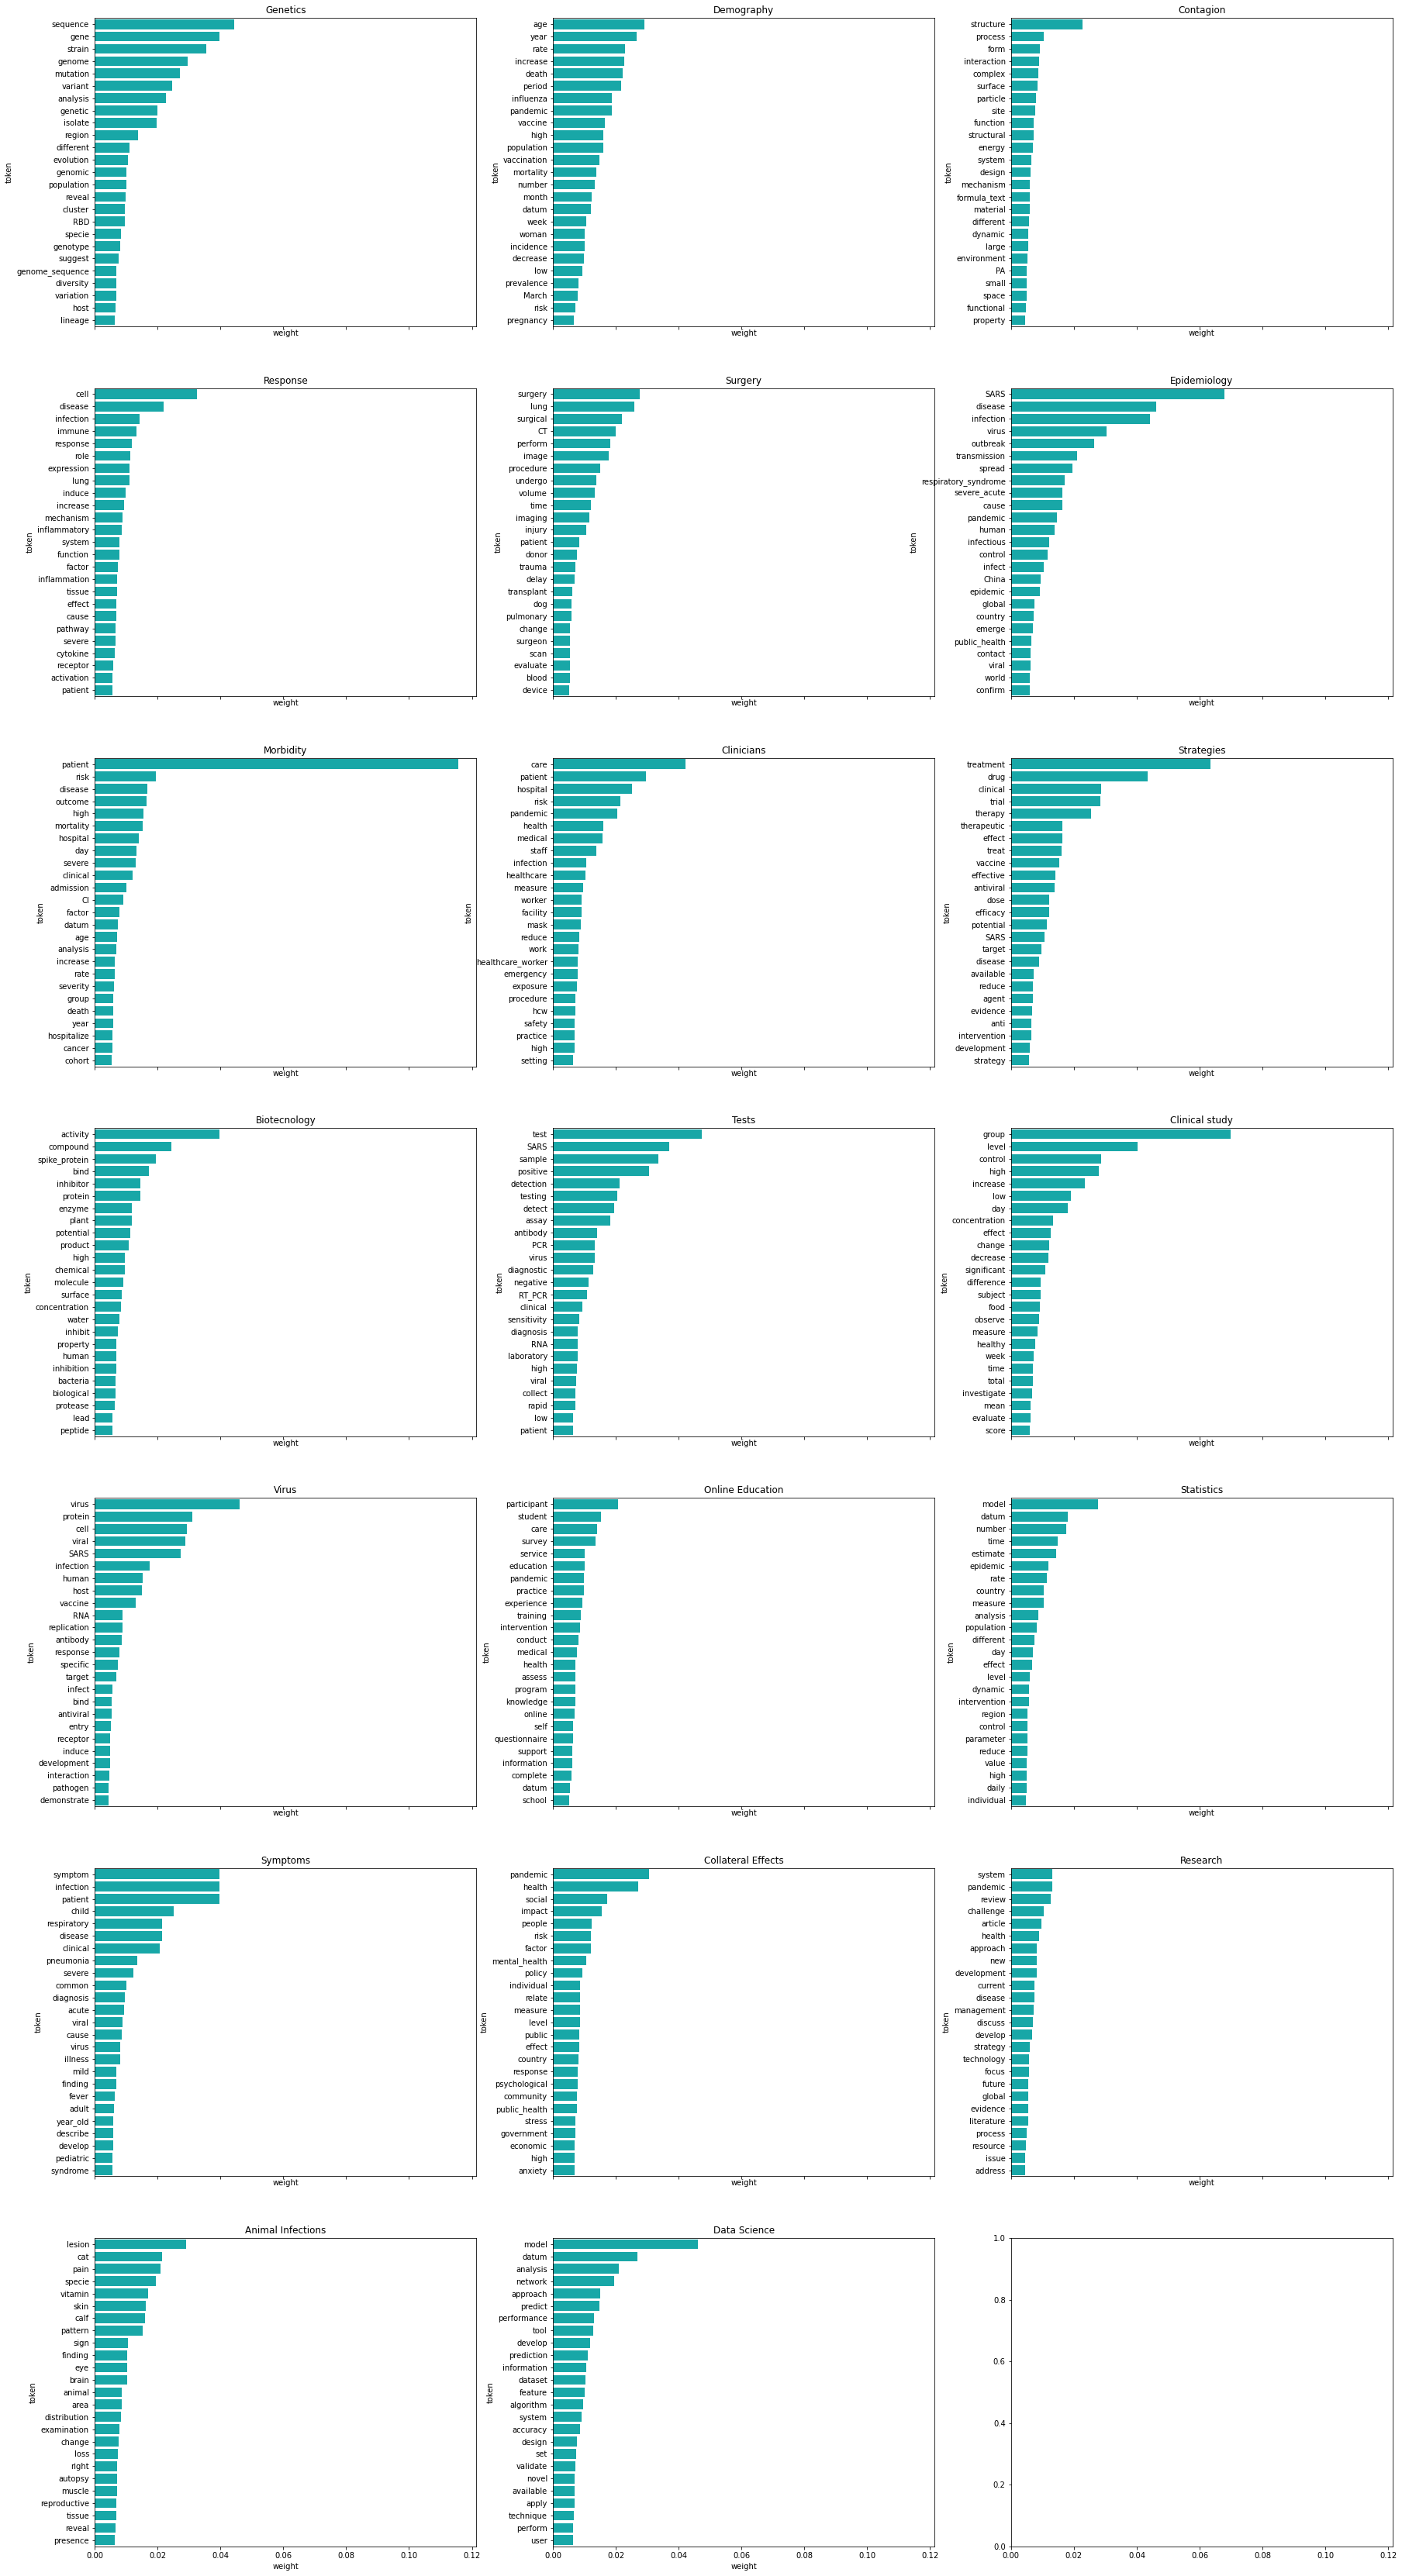

In [5]:
plots_per_row = 3
topn = 25

fig, axes = plt.subplots(math.ceil(n_topics / plots_per_row), plots_per_row, figsize=(30, 60), sharex=True)
x = 0

for i in range(n_topics):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df_weights = pd.DataFrame([{'token': t, 'weight': w} for t, w in ldag.show_topic(i, topn=topn)])
    
    ax = axes[x][i - (plots_per_row * x)]
    x += 1 if (i + 1) % plots_per_row == 0 else 0
    sns.barplot(x='weight', y='token', data=df_weights, color='c', orient='h', ax=ax)
    ax.set_title(names[i])
    
plt.show()

In [6]:
metadata_df = metadata_df.loc[~pd.isna(metadata_df['publish_time'])]

In [7]:
labels = list(set(metadata_df['publish_time'].dt.year.tolist()))

topic_count = []

for i in tqdm(range(n_topics)):
    count_ls = []
    for l in labels:
        count_ls.append(len(metadata_df.loc[(metadata_df['max_topic_id'] == i) & (metadata_df['publish_time'].dt.year == l)]))
    topic_count.append(count_ls)

100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


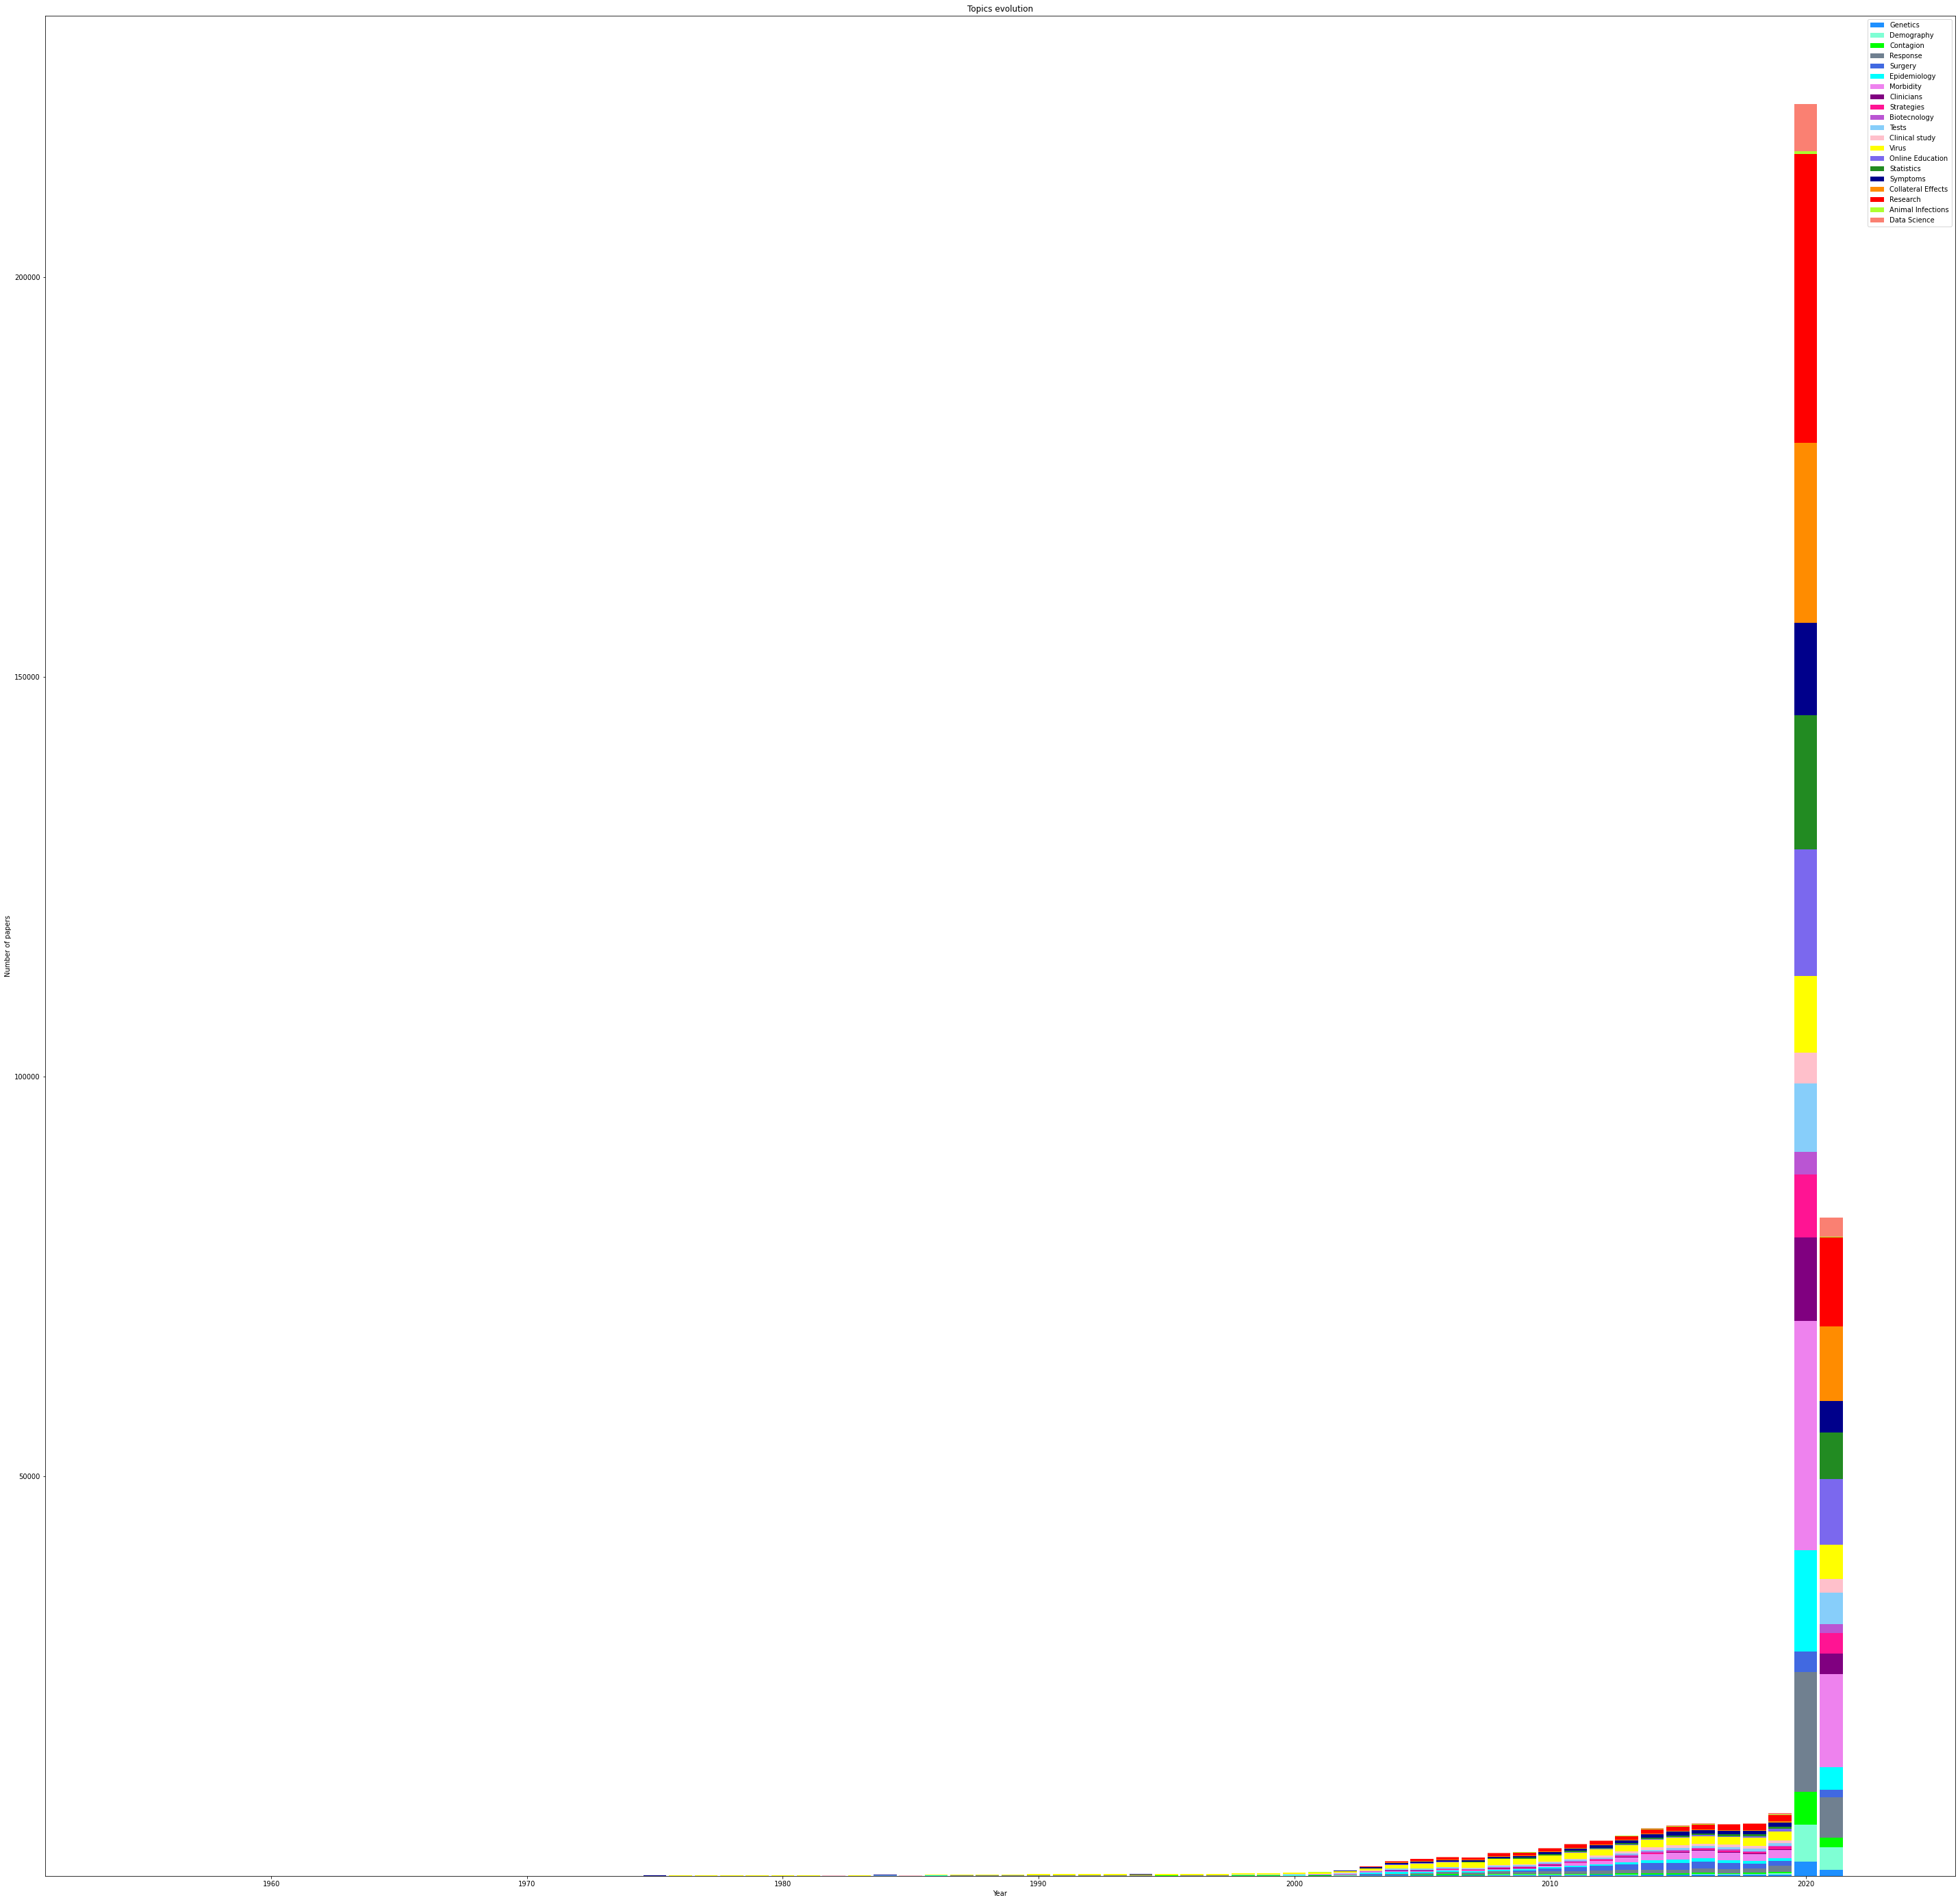

In [8]:
width = 0.9      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(50,50))

for i, c in zip(range(n_topics), colours):
    if i == 0:
        ax.bar(labels, topic_count[i], width, label=names[i], color=c)
    else:
        ax.bar(labels, topic_count[i], width, bottom=[sum(x) for x in zip(*topic_count[:i])], label=names[i], color=c)

ax.set_ylabel('Number of papers')
ax.set_xlabel('Year')
ax.set_title('Topics evolution')
ax.legend()

plt.show()

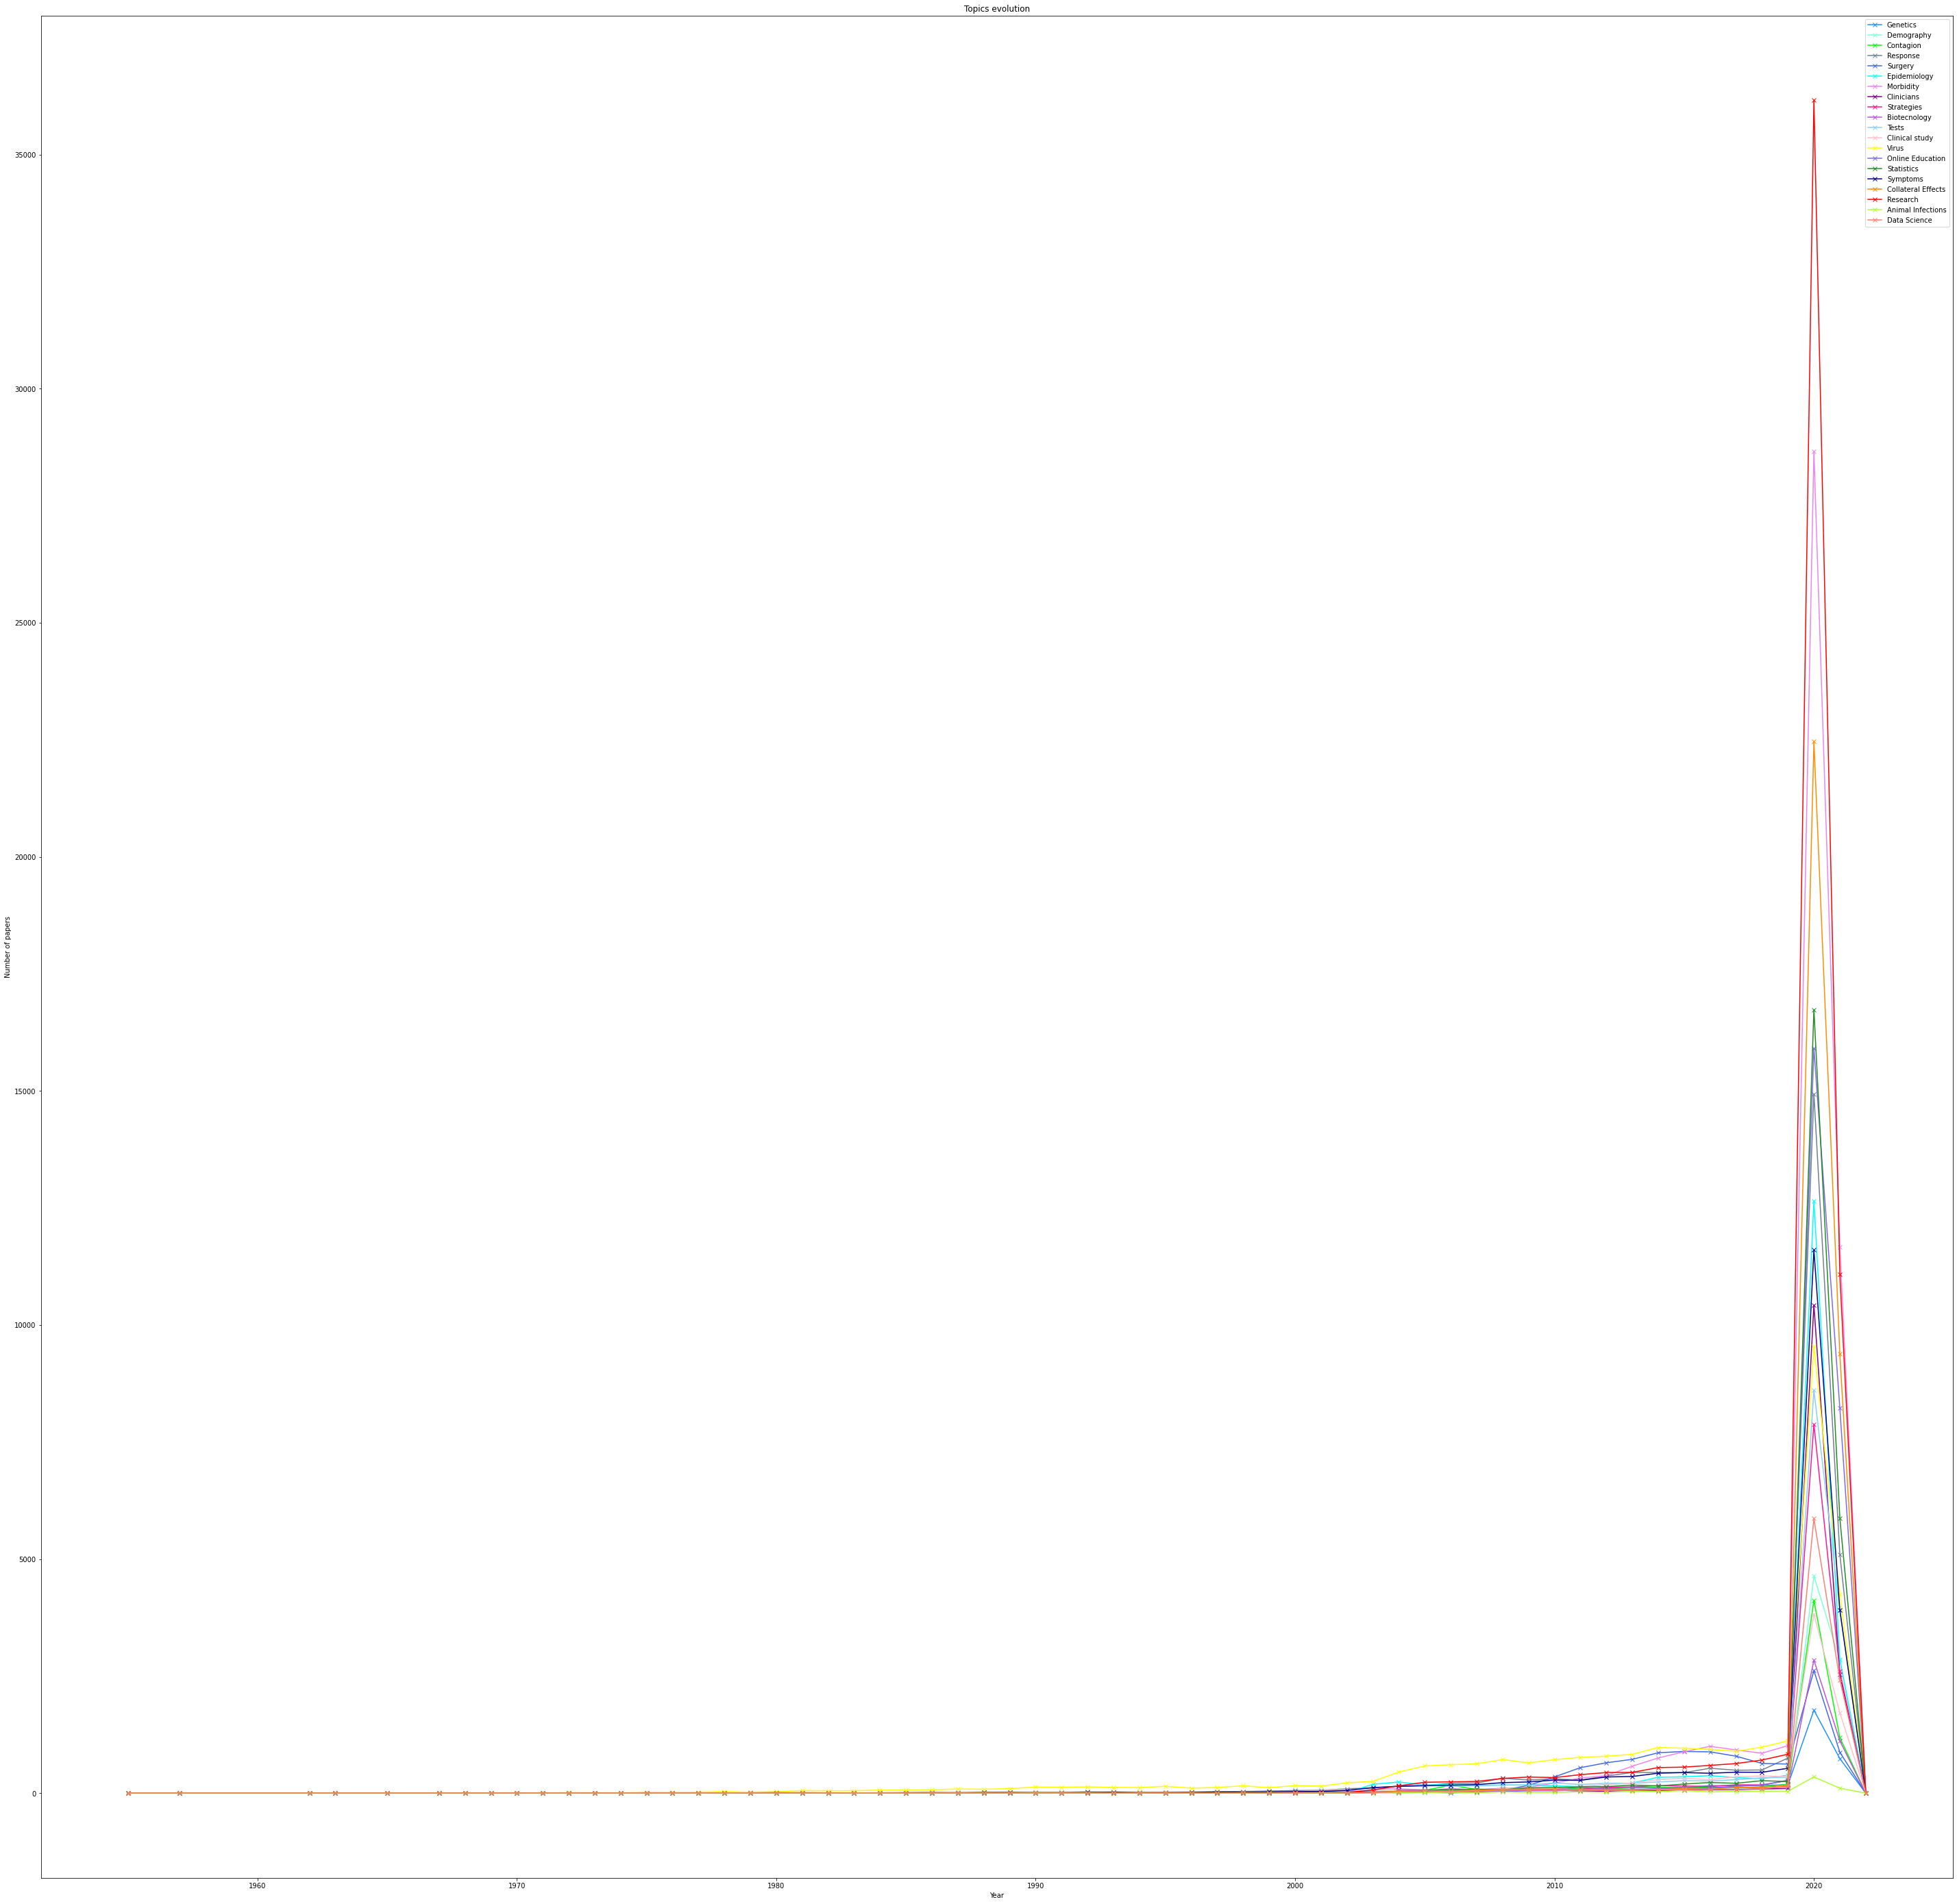

In [9]:
fig = plt.figure(figsize=(50,50))

for i, c in zip(range(n_topics), colours):
    plt.plot(labels, topic_count[i], label=names[i], color=c, marker='x')

plt.ylabel('Number of papers')
plt.xlabel('Year')
plt.title('Topics evolution')
plt.legend()

plt.show()

In [33]:
metadata_df_aux = metadata_df.loc[metadata_df['publish_time'].dt.year >= 2019]
labels = [str(y) + q for y in range(2019, 2022) for q in ['Q1', 'Q2', 'Q3', 'Q4']]

topic_count = []

for i in tqdm(range(n_topics)):
    count_ls = []
    for l in labels:
        count_ls.append(len(metadata_df_aux.loc[(metadata_df_aux['max_topic_id'] == i) & (metadata_df_aux['publish_time'].dt.to_period('Q').astype(str) == l)]))
    topic_count.append(count_ls)

100%|██████████| 20/20 [08:56<00:00, 26.82s/it]


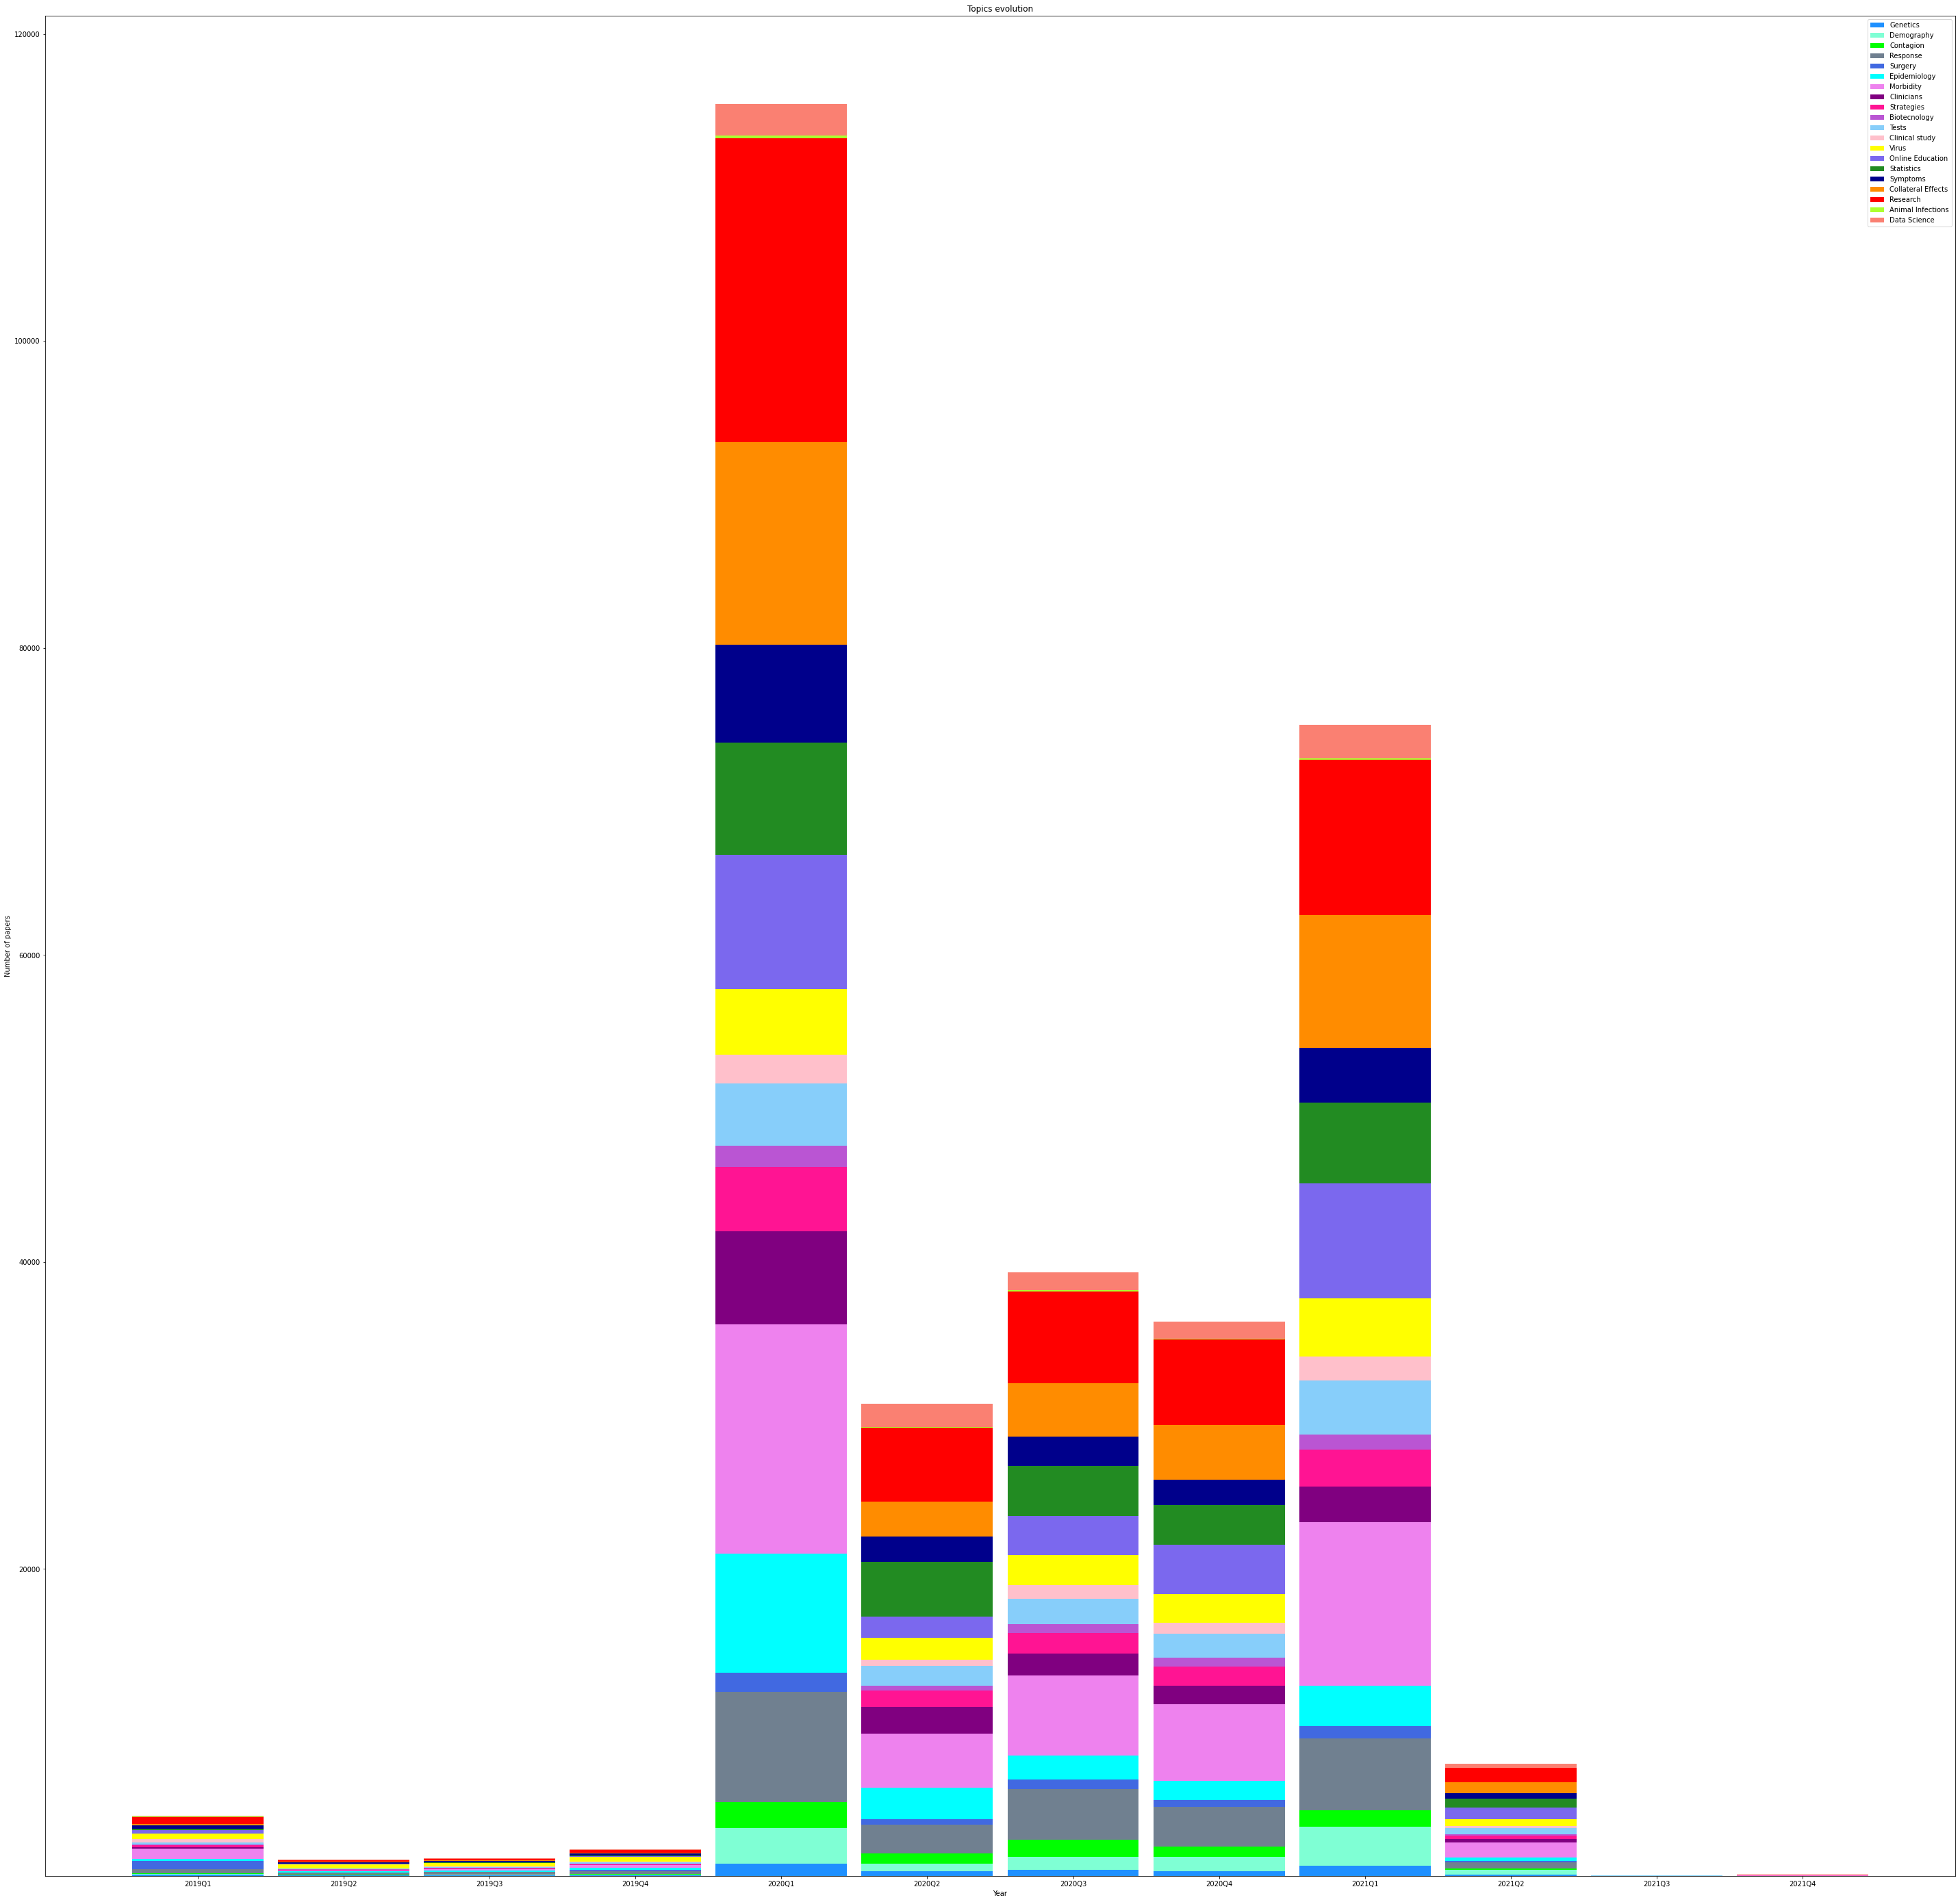

In [34]:
width = 0.9      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(50,50))

for i, c in zip(range(n_topics), colours):
    if i == 0:
        ax.bar(labels, topic_count[i], width, label=names[i], color=c)
    else:
        ax.bar(labels, topic_count[i], width, bottom=[sum(x) for x in zip(*topic_count[:i])], label=names[i], color=c)

ax.set_ylabel('Number of papers')
ax.set_xlabel('Year')
ax.set_title('Topics evolution')
ax.legend()

plt.show()

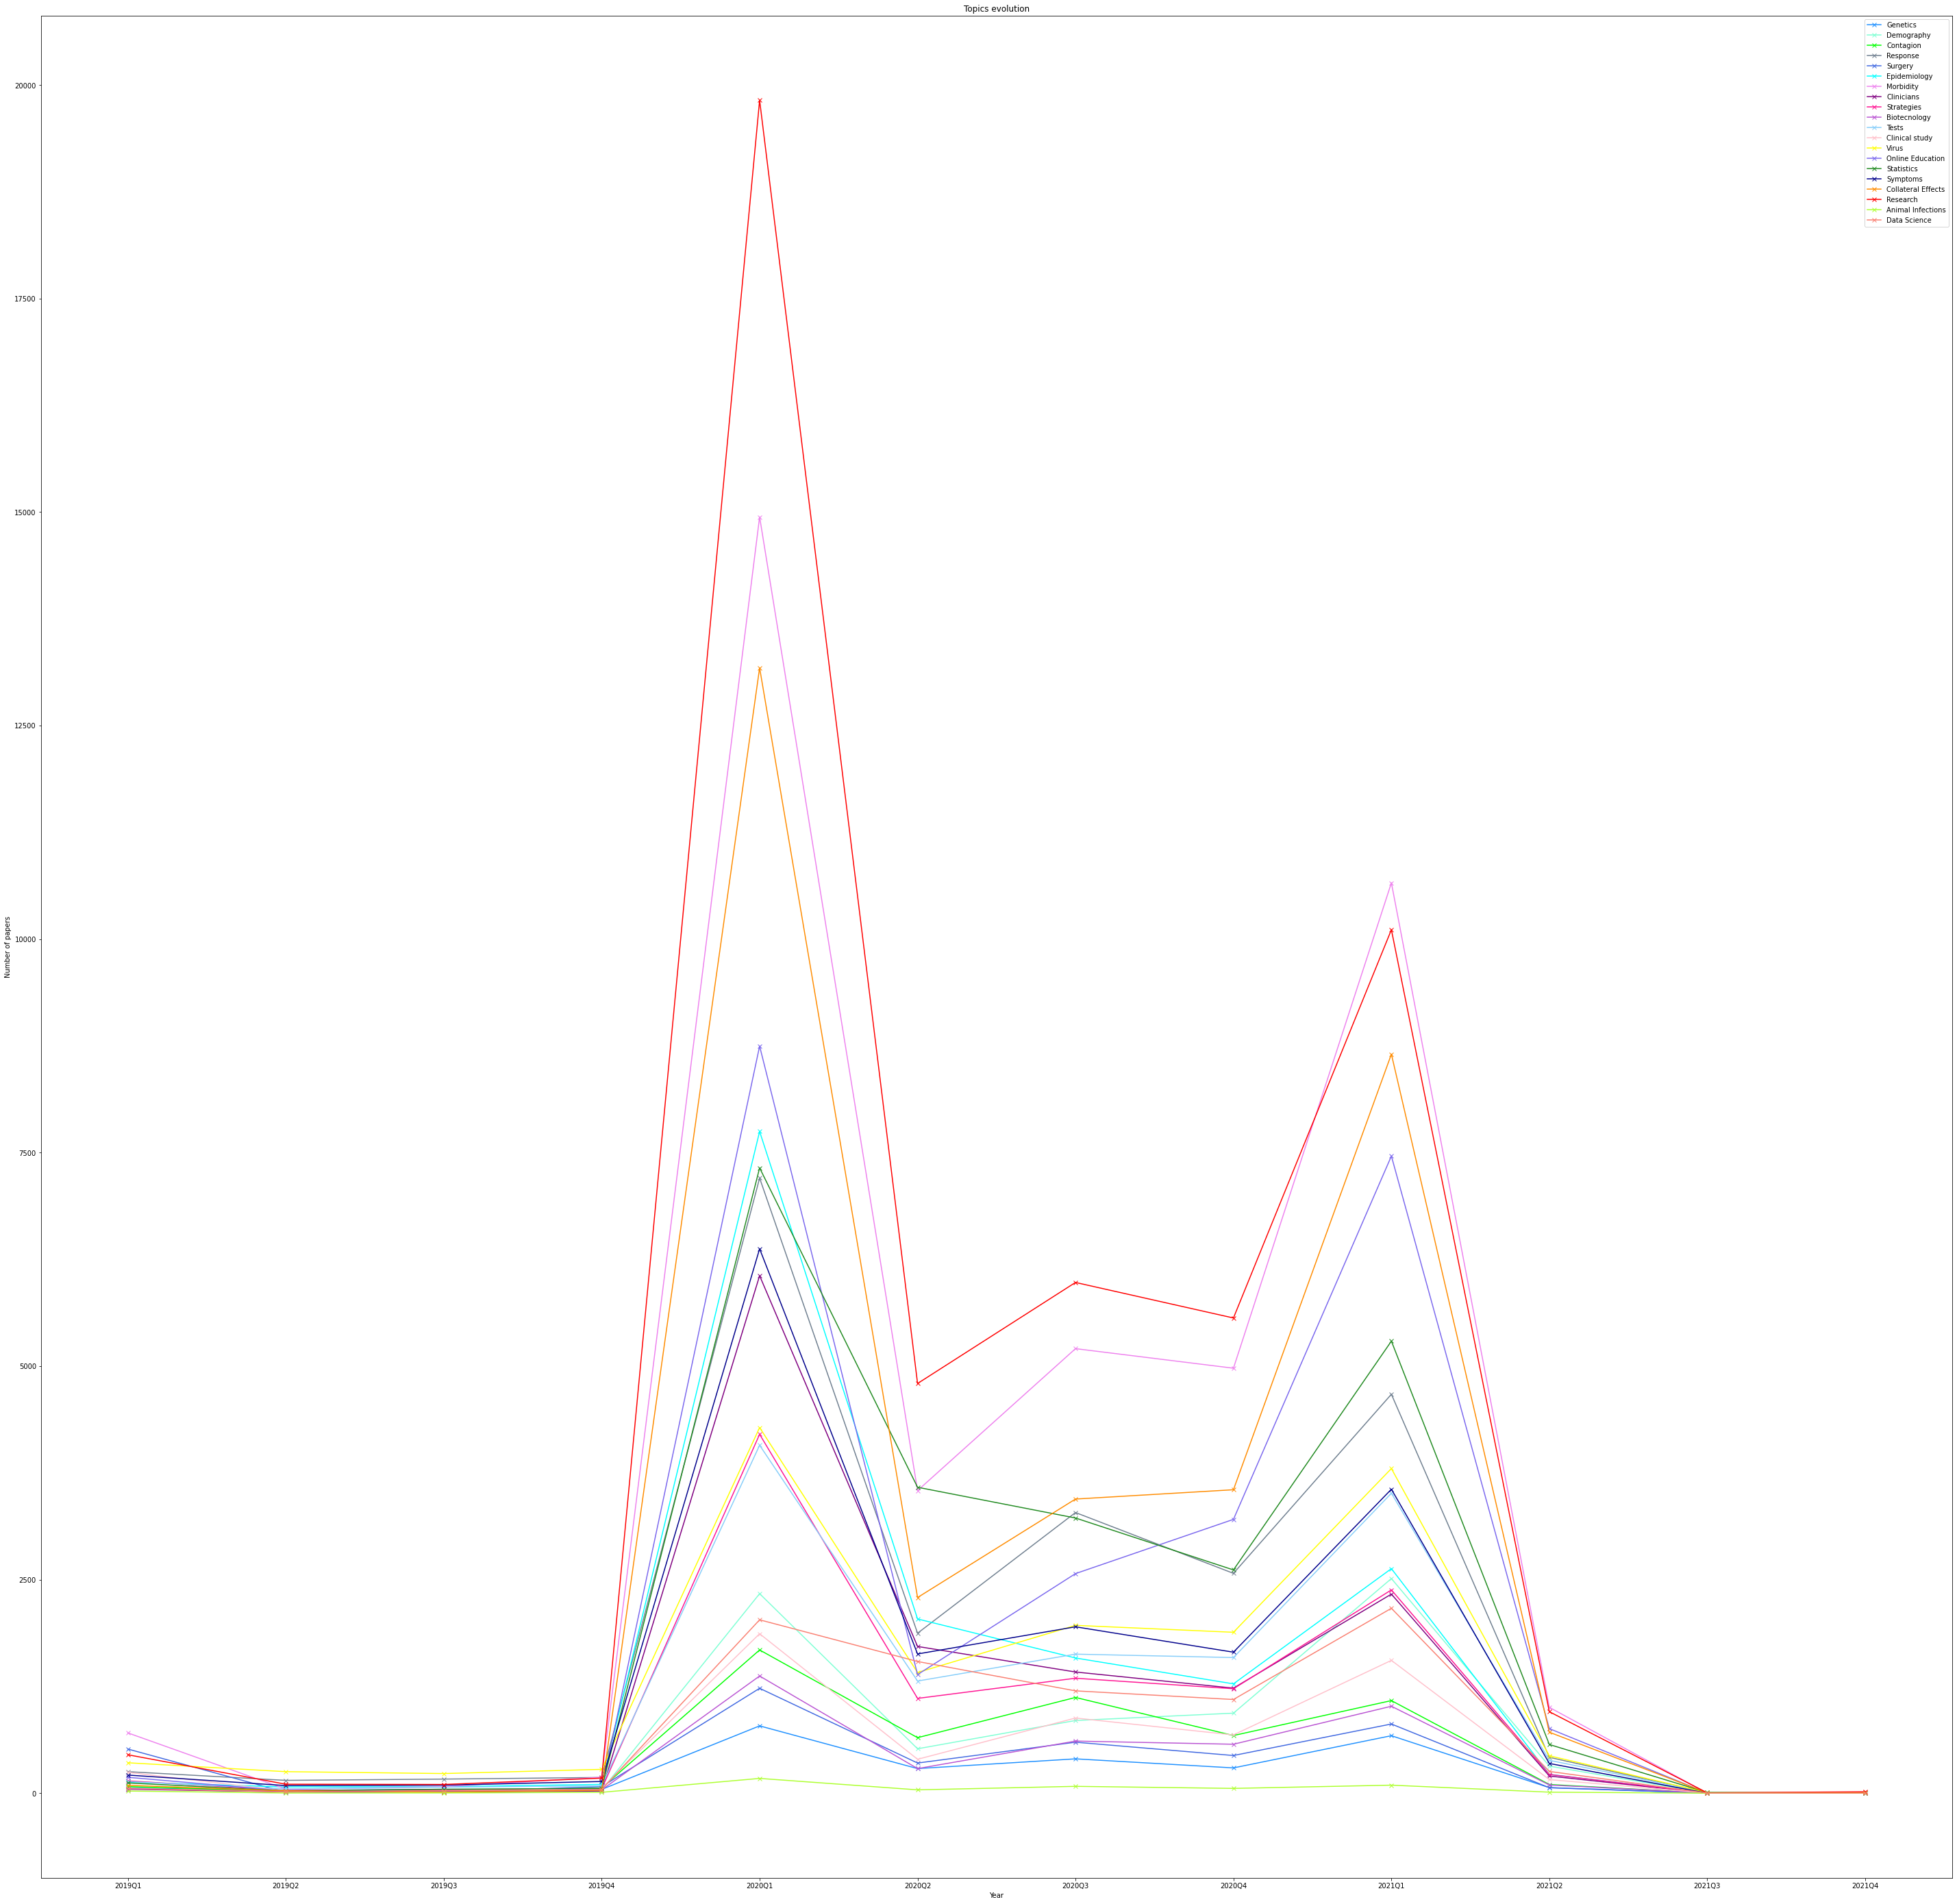

In [35]:
fig = plt.figure(figsize=(50,50))

for i, c in zip(range(n_topics), colours):
    plt.plot(labels, topic_count[i], label=names[i], color=c, marker='x')

plt.ylabel('Number of papers')
plt.xlabel('Year')
plt.title('Topics evolution')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
colors = dict(zip(
    ['India', 'Europe', 'Asia', 'Latin America',
     'Middle East', 'North America', 'Africa'],
    ['#adb0ff', '#ffb3ff', '#90d595', '#e48381',
     '#aafbff', '#f7bb5f', '#eafb50']
))
group_lk = df.set_index('name')['group'].to_dict()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
dff = dff[::-1]   # flip values from top to bottom
# pass colors values to `color=`
ax.barh(dff['name'], dff['value'], color=[colors[group_lk[x]] for x in dff['name']])
# iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
    ax.text(value, i,     name,            ha='right')  # Tokyo: name
    ax.text(value, i-.25, group_lk[name],  ha='right')  # Asia: group name
    ax.text(value, i,     value,           ha='left')   # 38194.2: value
# Add year right middle portion of canvas
ax.text(1, 0.4, current_year, transform=ax.transAxes, size=46, ha='right')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(year):
    dff = df[df['year'].eq(year)].sort_values(by='value', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['name'], dff['value'], color=[colors[group_lk[x]] for x in dff['name']])
    dx = dff['value'].max() / 200
    for i, (value, name) in enumerate(zip(dff['value'], dff['name'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The most populous cities in the world from 1500 to 2018',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by @pratapvardhan; credit @jburnmurdoch', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(2018)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1968, 2019))
HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save()